<a href="https://colab.research.google.com/github/btcain44/Applied_Deep_Learning/blob/main/Saliency_Map_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bi-Weekly Report #4
### Brian Cain 
#### Saliency_Map_Analysis.ipynb

In the previous notebook, <b>Edge_Detection_Ensemble.ipynb</b> I tried to explore a new way to make neural networks more robust through image transformation. In this notebook, I will go a step further to try and understand why neural networks make the decisions that they do. For this, I will generate Saliency Maps as described in the <b>Visualizing and Understanding</b> module in class. I will use the CIFAR-10 dataset but then filter it down to only pictures of mammals so I can concentrate my Saliency Maps visual analysis to a few image types. I will create two models, one which doesn't reduce the image resolution quite as much and then one which does and I'll assess how this changes the gradients over the image. 

In [1]:
##Import necessary packages for working with preliminary data
import tensorflow as tf
import numpy as np

##Import the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

##Transform y data to be more compatible
y_train = np.array([i[0] for i in y_train])
y_test = np.array([i[0] for i in y_test])

170508288/170498071 [==============================] - 3s 0us/step


From Tensorflow documentation we have the following information:

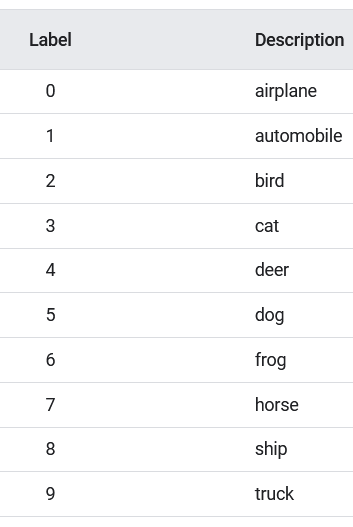

So, we would like to retain the data that has corresponding labels in the set {3,4,5,7} which respectively corresponds to {cat, deer, dog, horse}.

Additionally I will re-format the labels to have the following representations in the modified dataset: {0=Cat, 1=Deer, 2=Dog, 3=Horse}.

In [2]:
##Filter data to only be labels for the specified classes

##Determine indices to keep
train_indices = np.argwhere((y_train==3) | (y_train==4) | (y_train==5) | (y_train==7))[:,0]
test_indices = np.argwhere((y_test==3) | (y_test==4) | (y_test==5) | (y_test==7))[:,0]

##Only retain necessary indices
x_train = x_train[train_indices]
y_train = y_train[train_indices]
x_test = x_test[test_indices]
y_test = y_test[test_indices]

In [3]:
##Reassign labels to run from 0-3 as defined above

##Reassign the training set
y_train = np.where(y_train == 3,0,y_train)
y_train = np.where(y_train == 4,1,y_train)
y_train = np.where(y_train == 5,2,y_train)
y_train = np.where(y_train == 7,3,y_train)

##Reassign the test set
y_test = np.where(y_test == 3,0,y_test)
y_test = np.where(y_test == 4,1,y_test)
y_test = np.where(y_test == 5,2,y_test)
y_test = np.where(y_test == 7,3,y_test)

Now let's visualize some of the data to make sure we actually performed all these operations correctly: (Convienently I have a function to do this from previous notebooks)

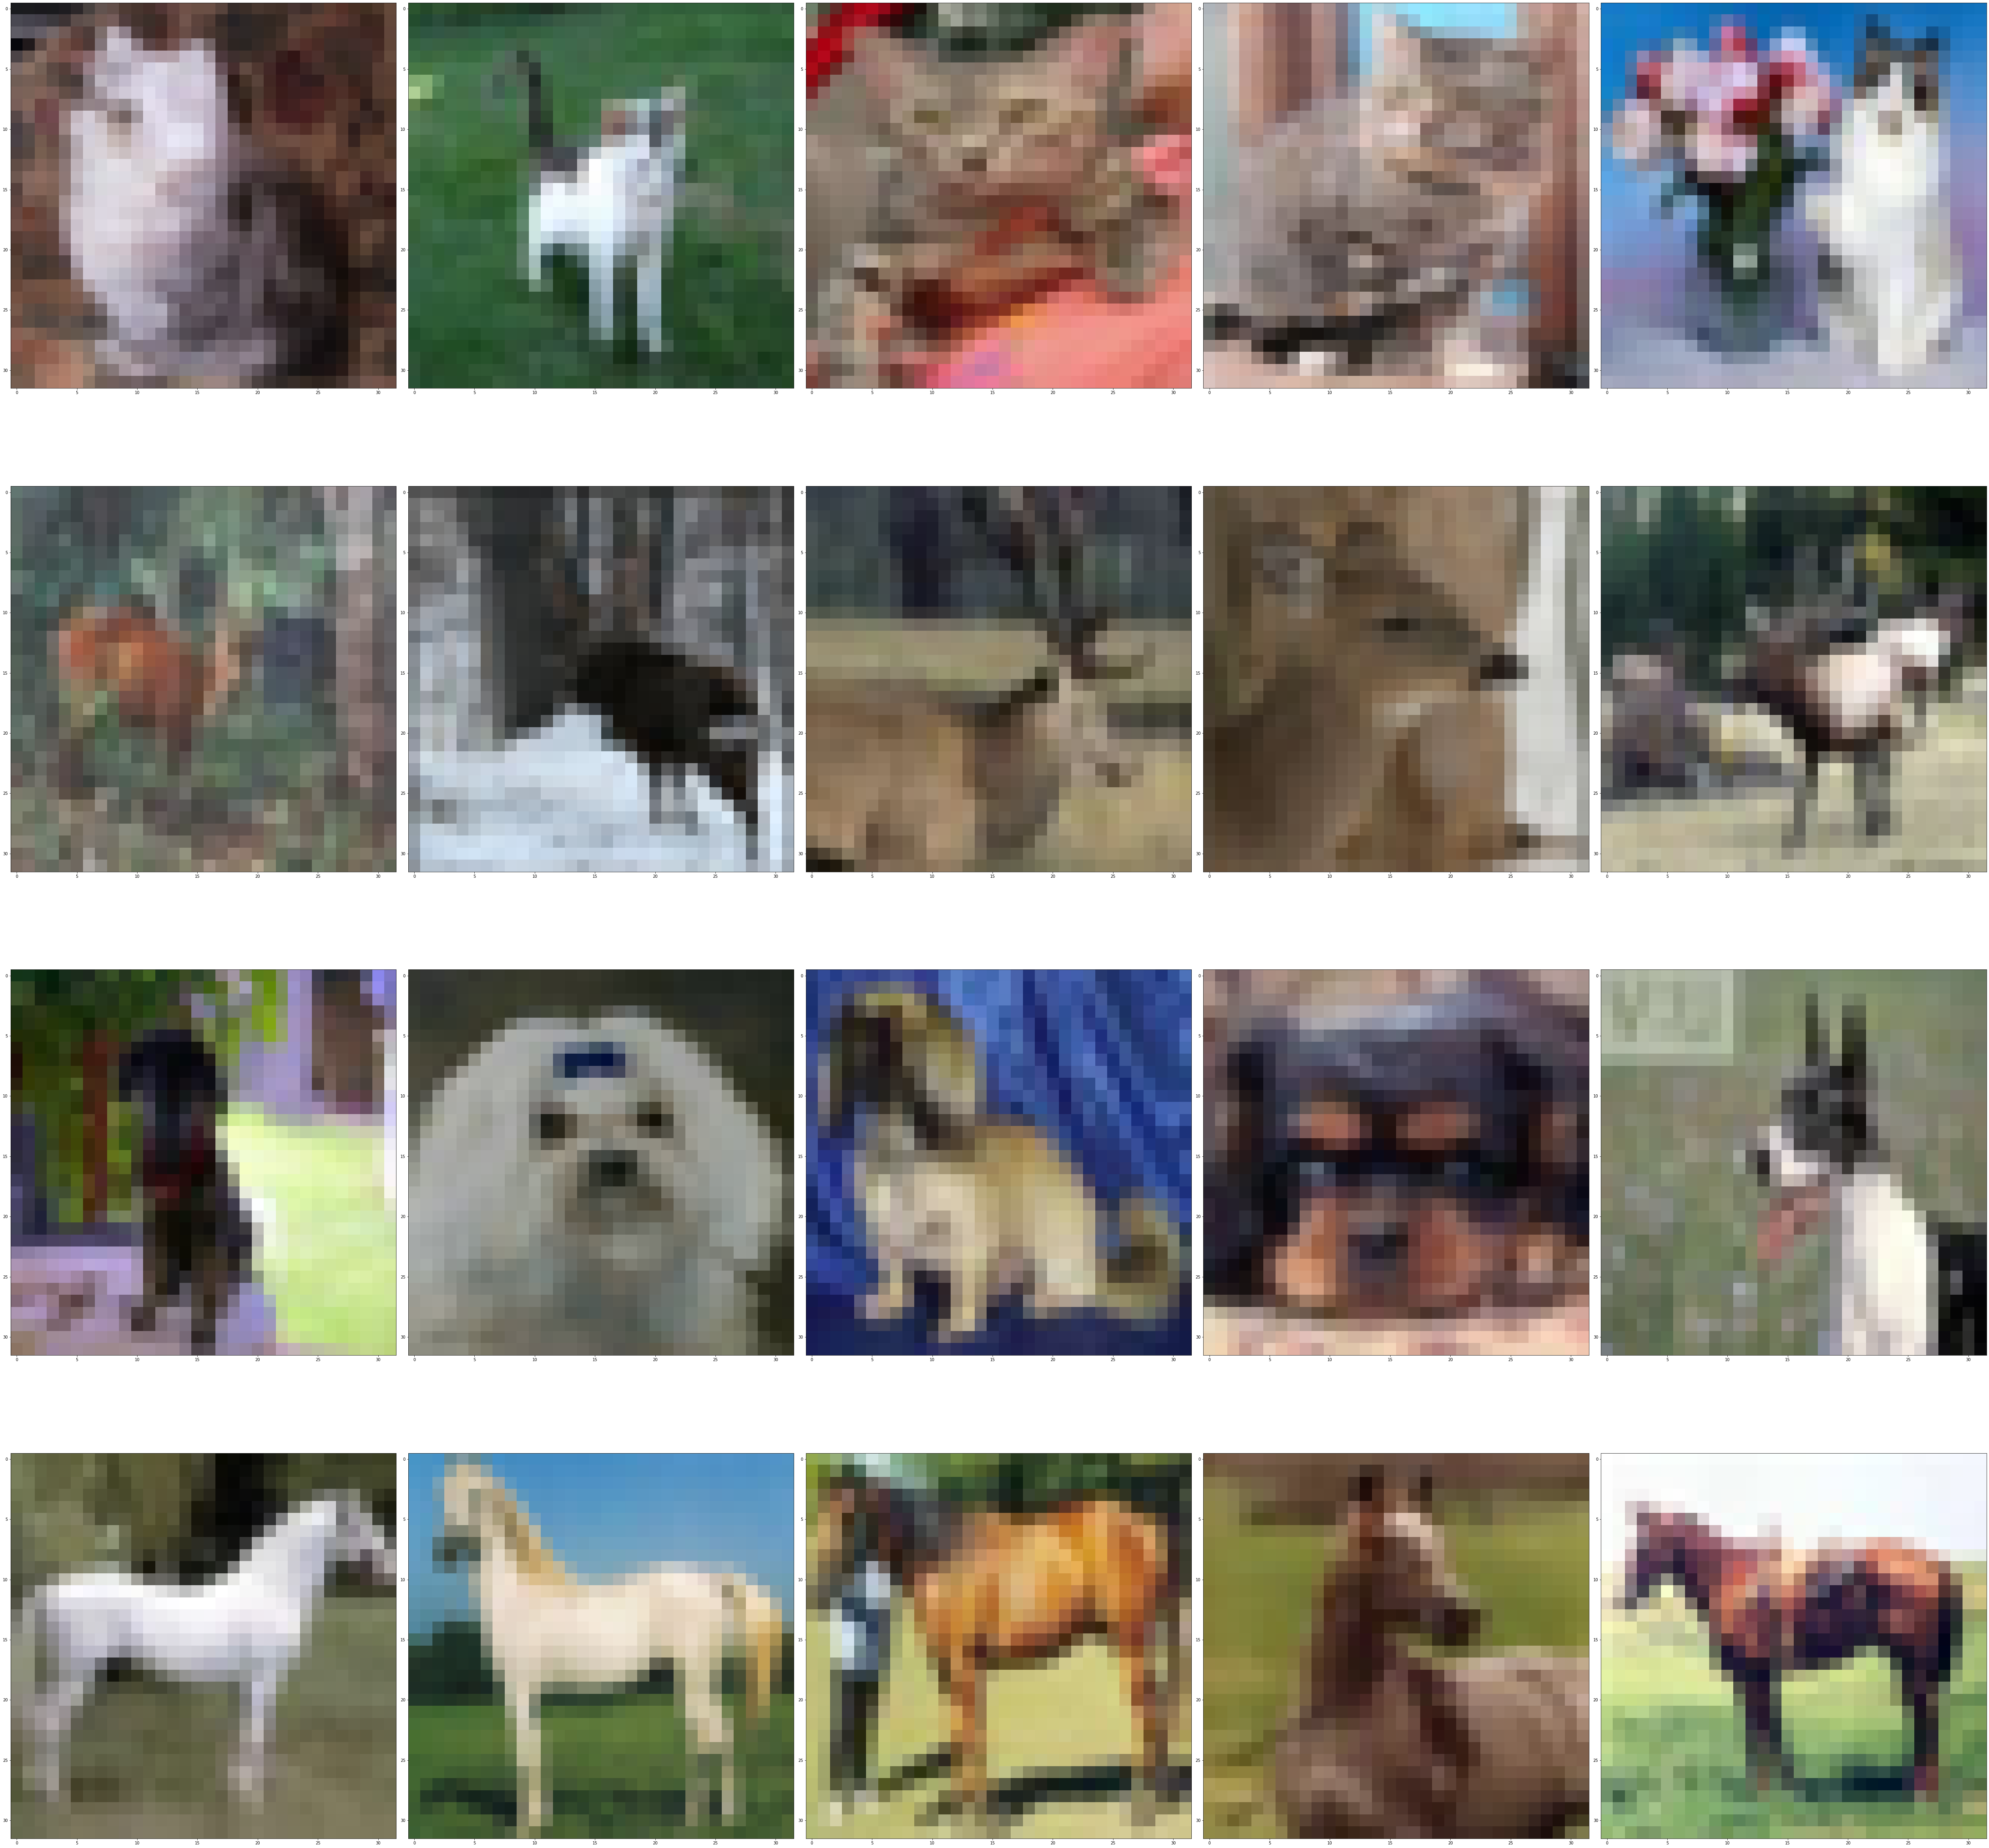

In [4]:
##Import plotting package
import matplotlib.pyplot as plt

##Use function to plot random image from previous notebooks
##Define a function that will display random samples for each class for us
def display_rand_samples(labels,num_samples,imgData_x,imgData_y):
  
  ##Create figure to output images onto
  fig, ax = plt.subplots(len(labels),num_samples,figsize=(70,70))

  ##Loop through labels to display random samples for each label onto subplot
  ct = 0
  for i in labels:
    randomSamples = imgData_x[np.random.choice(np.argwhere(imgData_y==i).flatten(),num_samples)]
    for j in range(num_samples):
      ax[ct,j].imshow(randomSamples[j],cmap='gray')
    ct+=1

  fig.tight_layout()

##Call the function to plot random observations from each super-class (coarse labels)
np.random.seed(2) ##Set random seed so visualization results can be replicated
display_rand_samples(list(np.unique(y_train)),5,x_train,y_train)

So it looks like the dataset was correctly filtered down to only the mammal classes that were desired. Now we can move onto training a model that preserves the higher resolution images throughout training and see what effects this has on the saliency maps. 

#### High Resolution Model

In [ ]:
##Create model
regularModel = tf.keras.models.Sequential()

##Add a layer with 32 filters for a 1x1 convolution
regularModel.add(tf.keras.layers.Conv2D(32, (1, 1), activation='relu', input_shape=(32,32,3))) ##Grayscale input shape
#regularModel.add(tf.keras.layers.MaxPooling2D((3, 3),padding='valid')) ##Perform a 3x3 max-pooling

##Add a layer that generates 64 feature maps and max pools again with 3x3 
regularModel.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
regularModel.add(tf.keras.layers.MaxPooling2D((3, 3)))

##Perform final convolution operations and conduct global average pooling
regularModel.add(tf.keras.layers.Conv2D(64, (1, 1), activation='relu'))
regularModel.add(tf.keras.layers.GlobalAveragePooling2D())

##Add a single dense layer after global average pooling
regularModel.add(tf.keras.layers.Dense(4, activation='softmax')) ##Must have 9 neurons

In [ ]:
##Check the architecture of our network
regularModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          4160      
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 2

Now I will compile the model:

In [ ]:
##Compile the model
regularModel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

##Split training data so we have a validation set
from sklearn.model_selection import train_test_split
x_train_regular, x_val, y_train_regular, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [ ]:
##Fit our created model over 50 epochs
regularModel_fit = regularModel.fit(x_train_regular, y_train_regular, batch_size=32, epochs=50, validation_data=(x_val, y_val),verbose=2)

Epoch 1/50
469/469 - 4s - loss: 1.5767 - accuracy: 0.3757 - val_loss: 1.2543 - val_accuracy: 0.4170
Epoch 2/50
469/469 - 3s - loss: 1.2130 - accuracy: 0.4507 - val_loss: 1.1614 - val_accuracy: 0.4822
Epoch 3/50
469/469 - 3s - loss: 1.1660 - accuracy: 0.4759 - val_loss: 1.1187 - val_accuracy: 0.5074
Epoch 4/50
469/469 - 3s - loss: 1.1284 - accuracy: 0.4979 - val_loss: 1.1024 - val_accuracy: 0.5082
Epoch 5/50
469/469 - 3s - loss: 1.0998 - accuracy: 0.5177 - val_loss: 1.1877 - val_accuracy: 0.4642
Epoch 6/50
469/469 - 3s - loss: 1.0838 - accuracy: 0.5285 - val_loss: 1.0567 - val_accuracy: 0.5384
Epoch 7/50
469/469 - 3s - loss: 1.0705 - accuracy: 0.5306 - val_loss: 1.0951 - val_accuracy: 0.5226
Epoch 8/50
469/469 - 3s - loss: 1.0599 - accuracy: 0.5389 - val_loss: 1.0472 - val_accuracy: 0.5434
Epoch 9/50
469/469 - 3s - loss: 1.0471 - accuracy: 0.5487 - val_loss: 1.0155 - val_accuracy: 0.5666
Epoch 10/50
469/469 - 3s - loss: 1.0365 - accuracy: 0.5518 - val_loss: 1.0655 - val_accuracy: 0.5374

Now lets assess the test accuracy of the model trained on regular data:

In [ ]:
##Evaluate the models accuracy on the MNIST dataset
print('Test Accuracy of Regular Model:')
regularModel.evaluate(x_test,  y_test, verbose=0)[1]

Test Accuracy of Regular Model:


0.5857499837875366

This model doesn't have the best accuracy, specifically considering there were only 4 classes to predict. It did suffer some over-fitting with a test accuracy of 58.57%, which is a decrease from the final validation accuracy of 63.78%. 

#### High Resolution Saliency Map Analysis:

From the following resource as an aid: https://usmanr149.github.io/urmlblog/cnn2020/05/01/Salincy-Maps.html I was able to create a function that shows the saliency maps generated for certain images by the keras sequential model. 

In [16]:
##Define function that returns the saliency map for an image based on the model
def saliency_map(img,model,x_test):

  ##Format the image
  img = img.reshape((1, *img.shape))
  y_pred = model.predict(img)
  images = tf.Variable(img, dtype=float)

  ##Change pixels to assess how prediction for the image changes
  with tf.GradientTape() as tape:
      pred = model(images, training=False)
      class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
      loss = pred[0][class_idxs_sorted[0]]
  
  ##Compute the necessary gradients for the saliency map
  grads = tape.gradient(loss, images)
  dgrad_abs = tf.math.abs(grads)
  dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

  ##Normalize gradients between 0 and 1
  arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
  grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

  return grad_eval

Now lets pick some random images from the testing dataset and determine what parts of the images are most important to the algorithm according to the saliency map, I will save written analysis for after all visualizations have been generated for each class:

In [12]:
##Get random data for each label class we have for mammals
randCats = x_test[np.random.choice(np.argwhere(y_test==0).flatten(),6)]
randDeer = x_test[np.random.choice(np.argwhere(y_test==1).flatten(),6)]
randDogs = x_test[np.random.choice(np.argwhere(y_test==2).flatten(),6)]
randHorses = x_test[np.random.choice(np.argwhere(y_test==3).flatten(),6)]

<b>Plot Saliency Maps for Random Cat Images:</b>

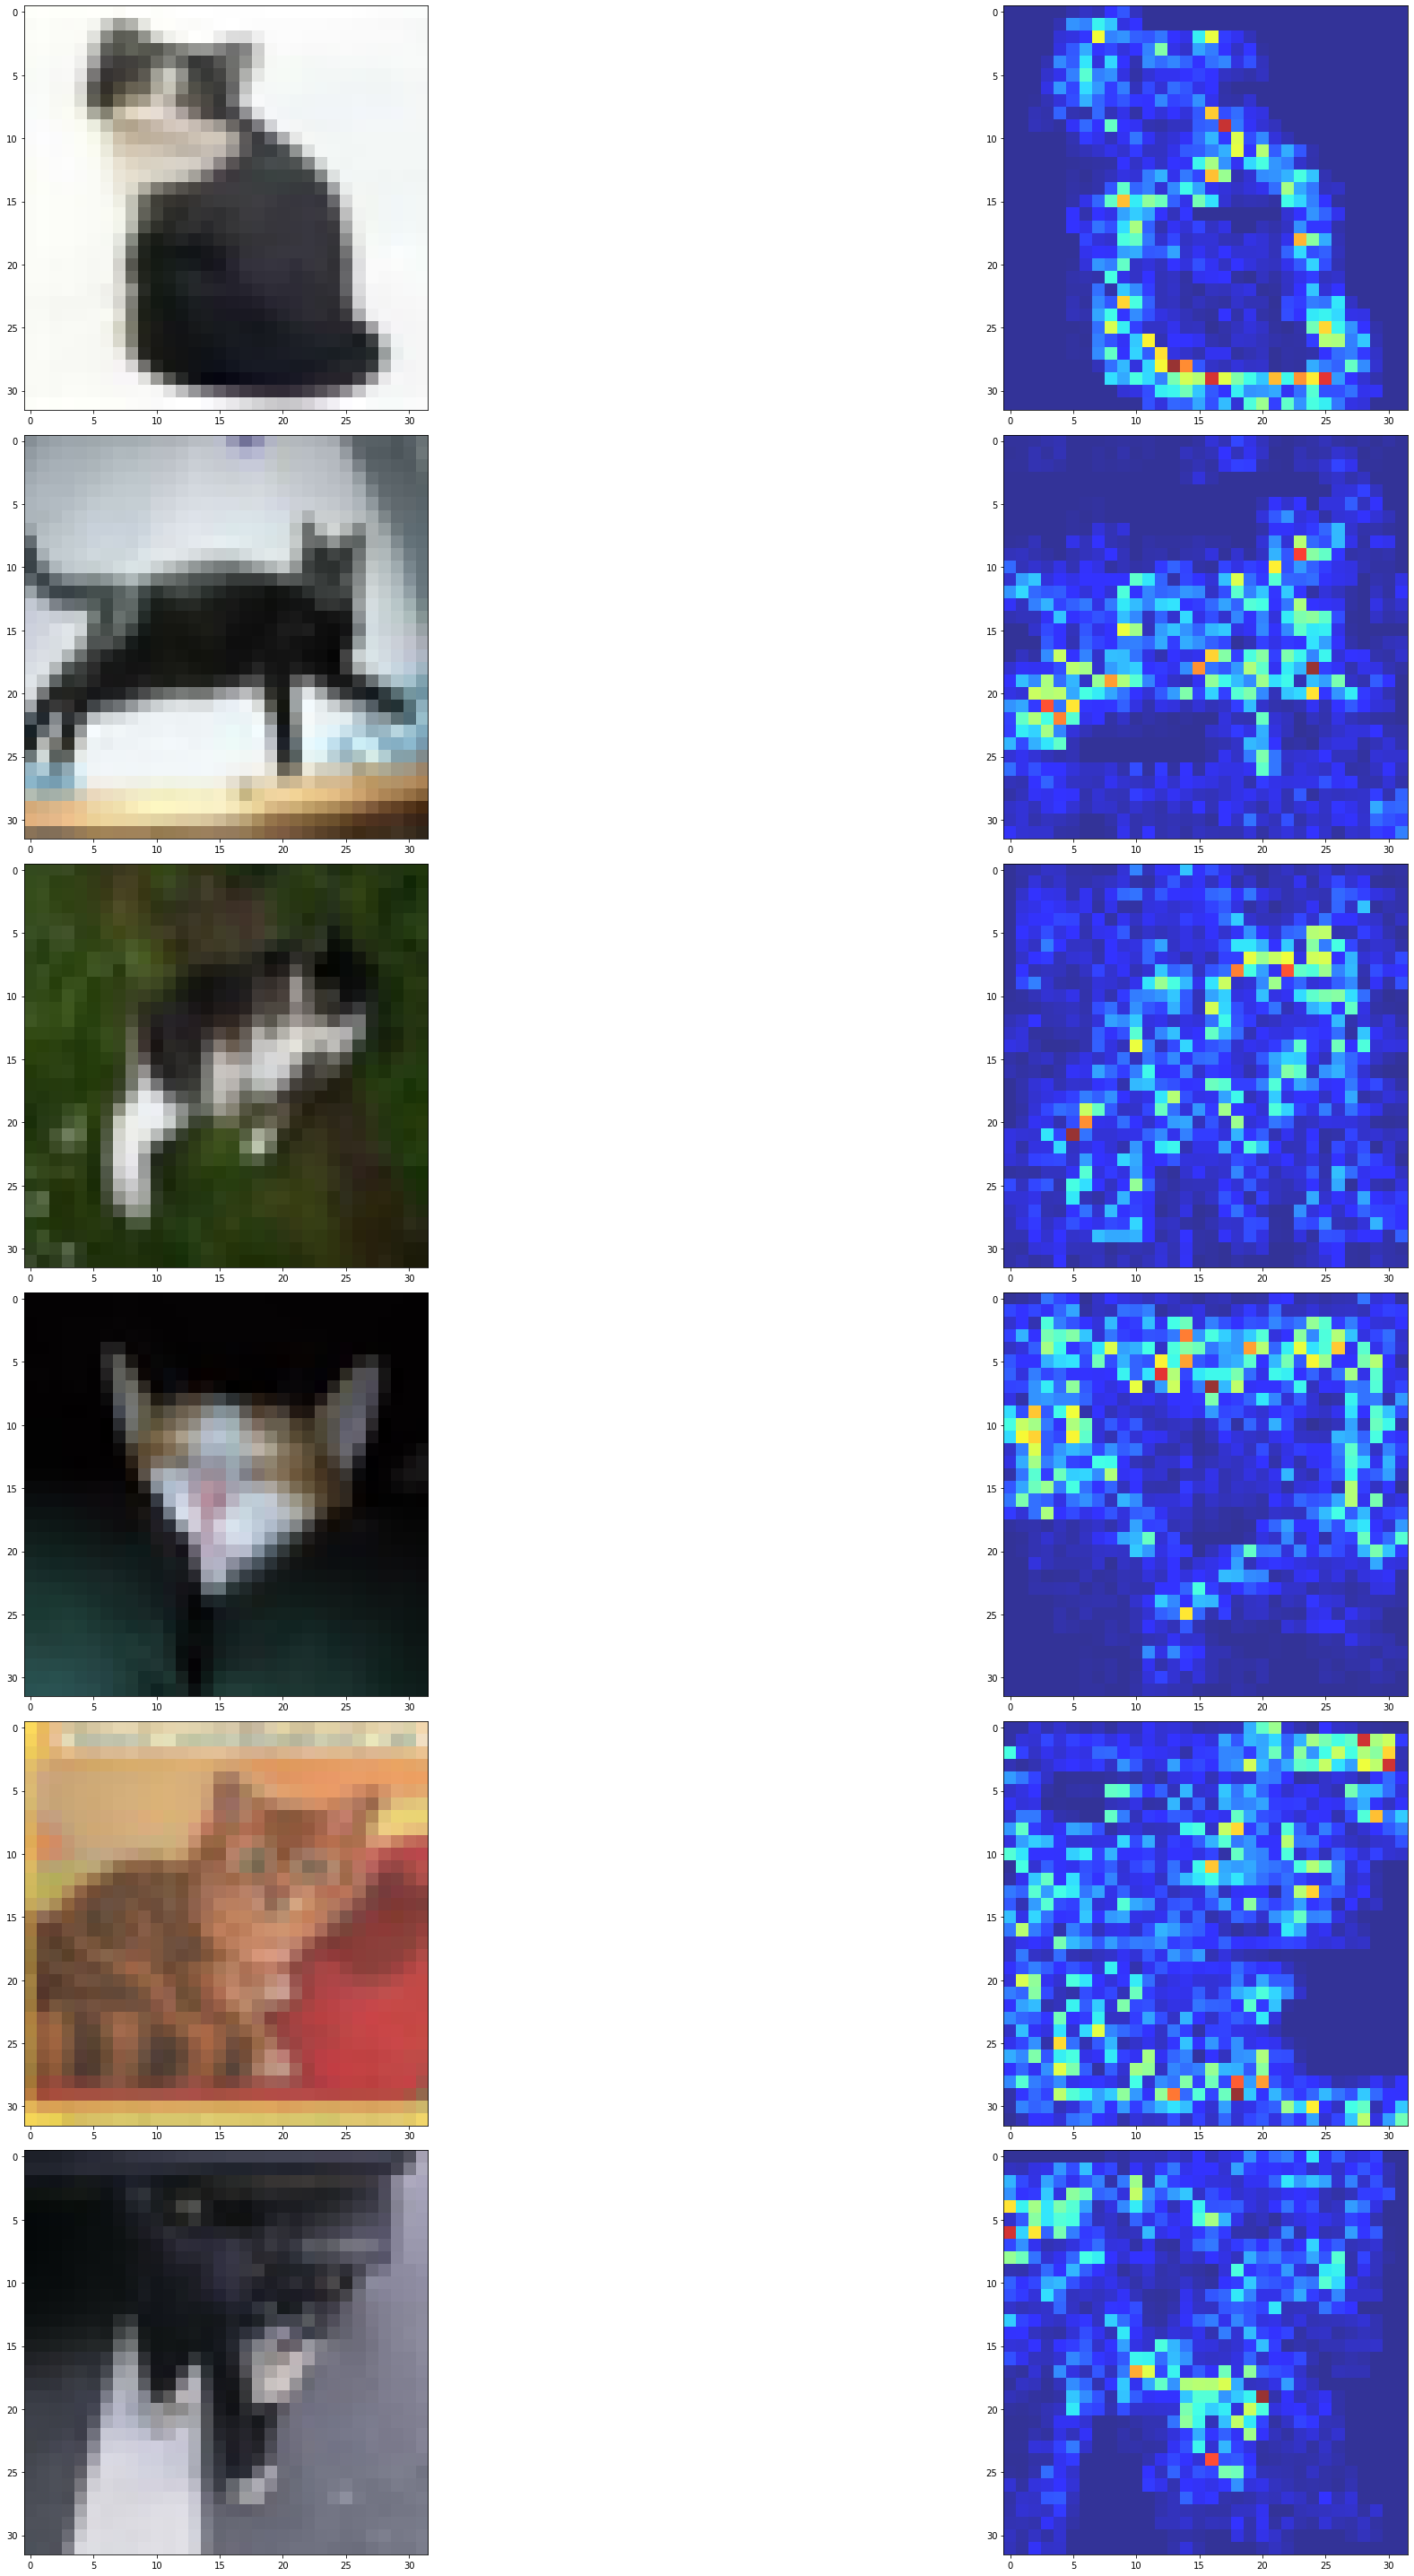

In [ ]:
##Create the subplot object
fig, axes = plt.subplots(6,2,figsize=(40,40))

##Loop through all the random cat images
ct = 0
for i in randCats:
  map = saliency_map(i,regularModel,x_test)
  axes[ct,0].imshow(np.squeeze(i))
  axes[ct,1].imshow(map,cmap="jet",alpha=0.8)
  ct+=1
fig.tight_layout()

<b>Plot Saliency Maps for Deer:</b>

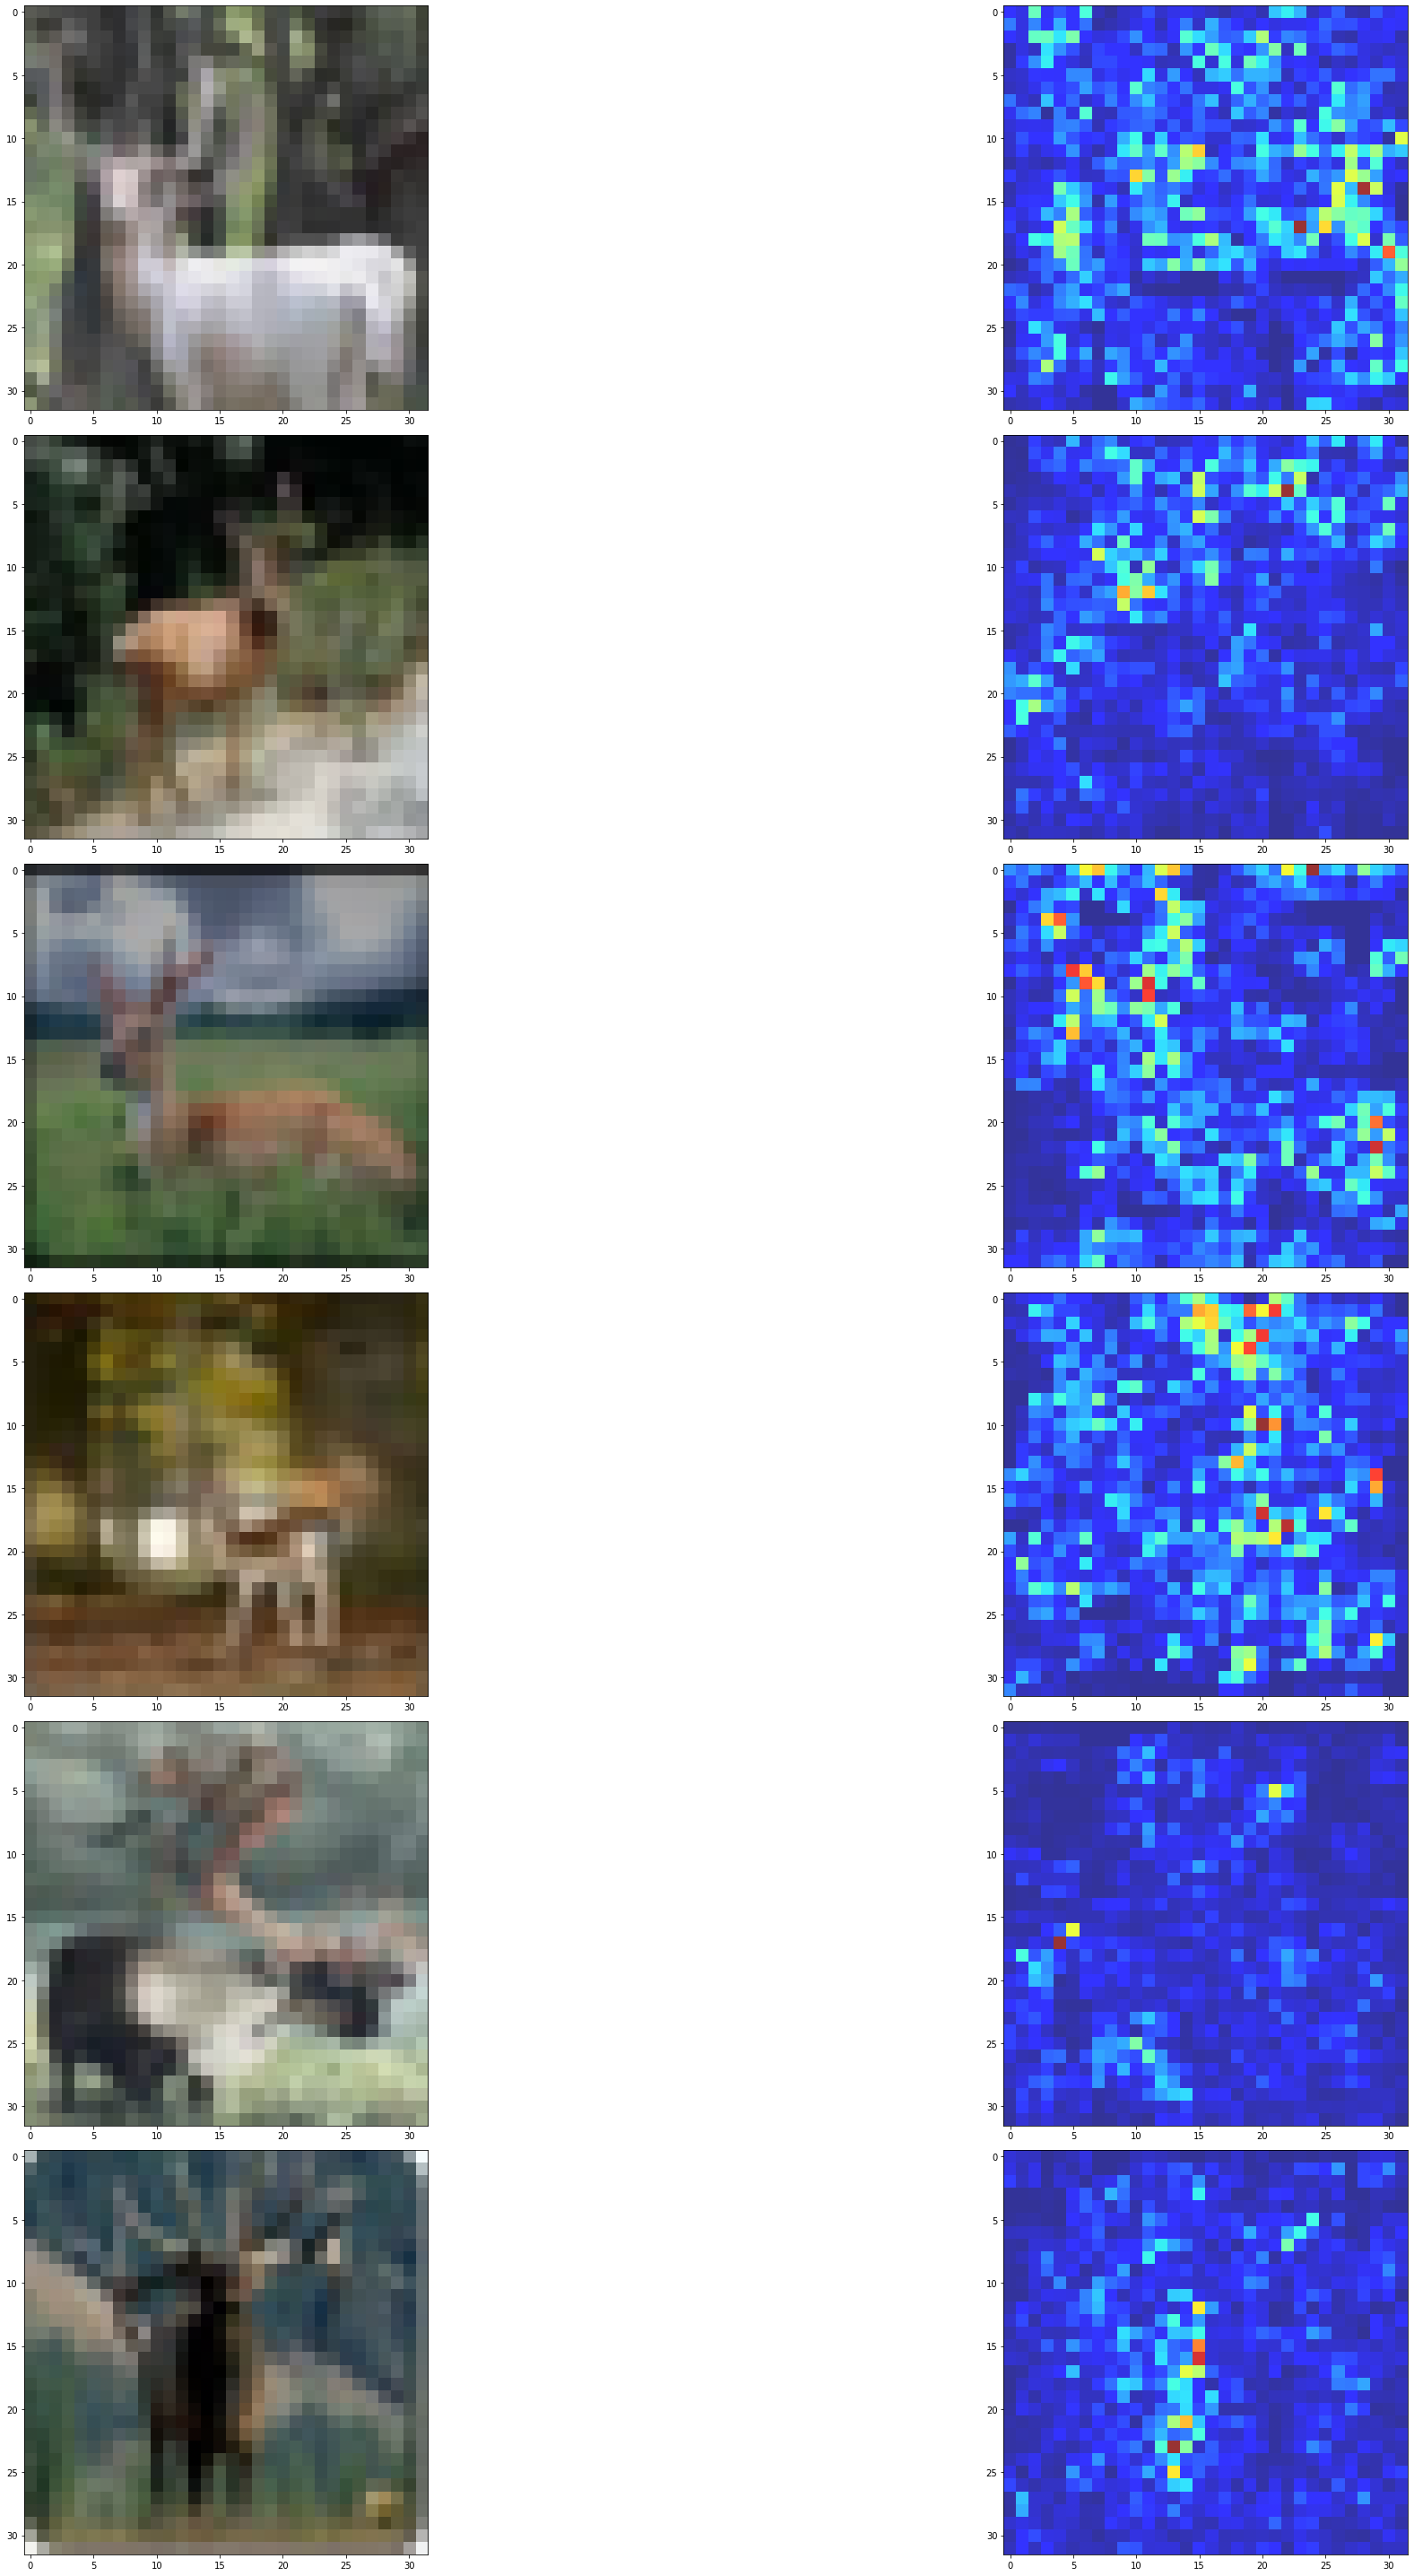

In [ ]:
##Create the subplot object
fig, axes = plt.subplots(6,2,figsize=(40,40))

##Loop through all the random cat images
ct = 0
for i in randDeer:
  map = saliency_map(i,regularModel,x_test)
  axes[ct,0].imshow(np.squeeze(i))
  axes[ct,1].imshow(map,cmap="jet",alpha=0.8)
  ct+=1
fig.tight_layout()

<b>Plot Saliency Maps for Dog:</b>

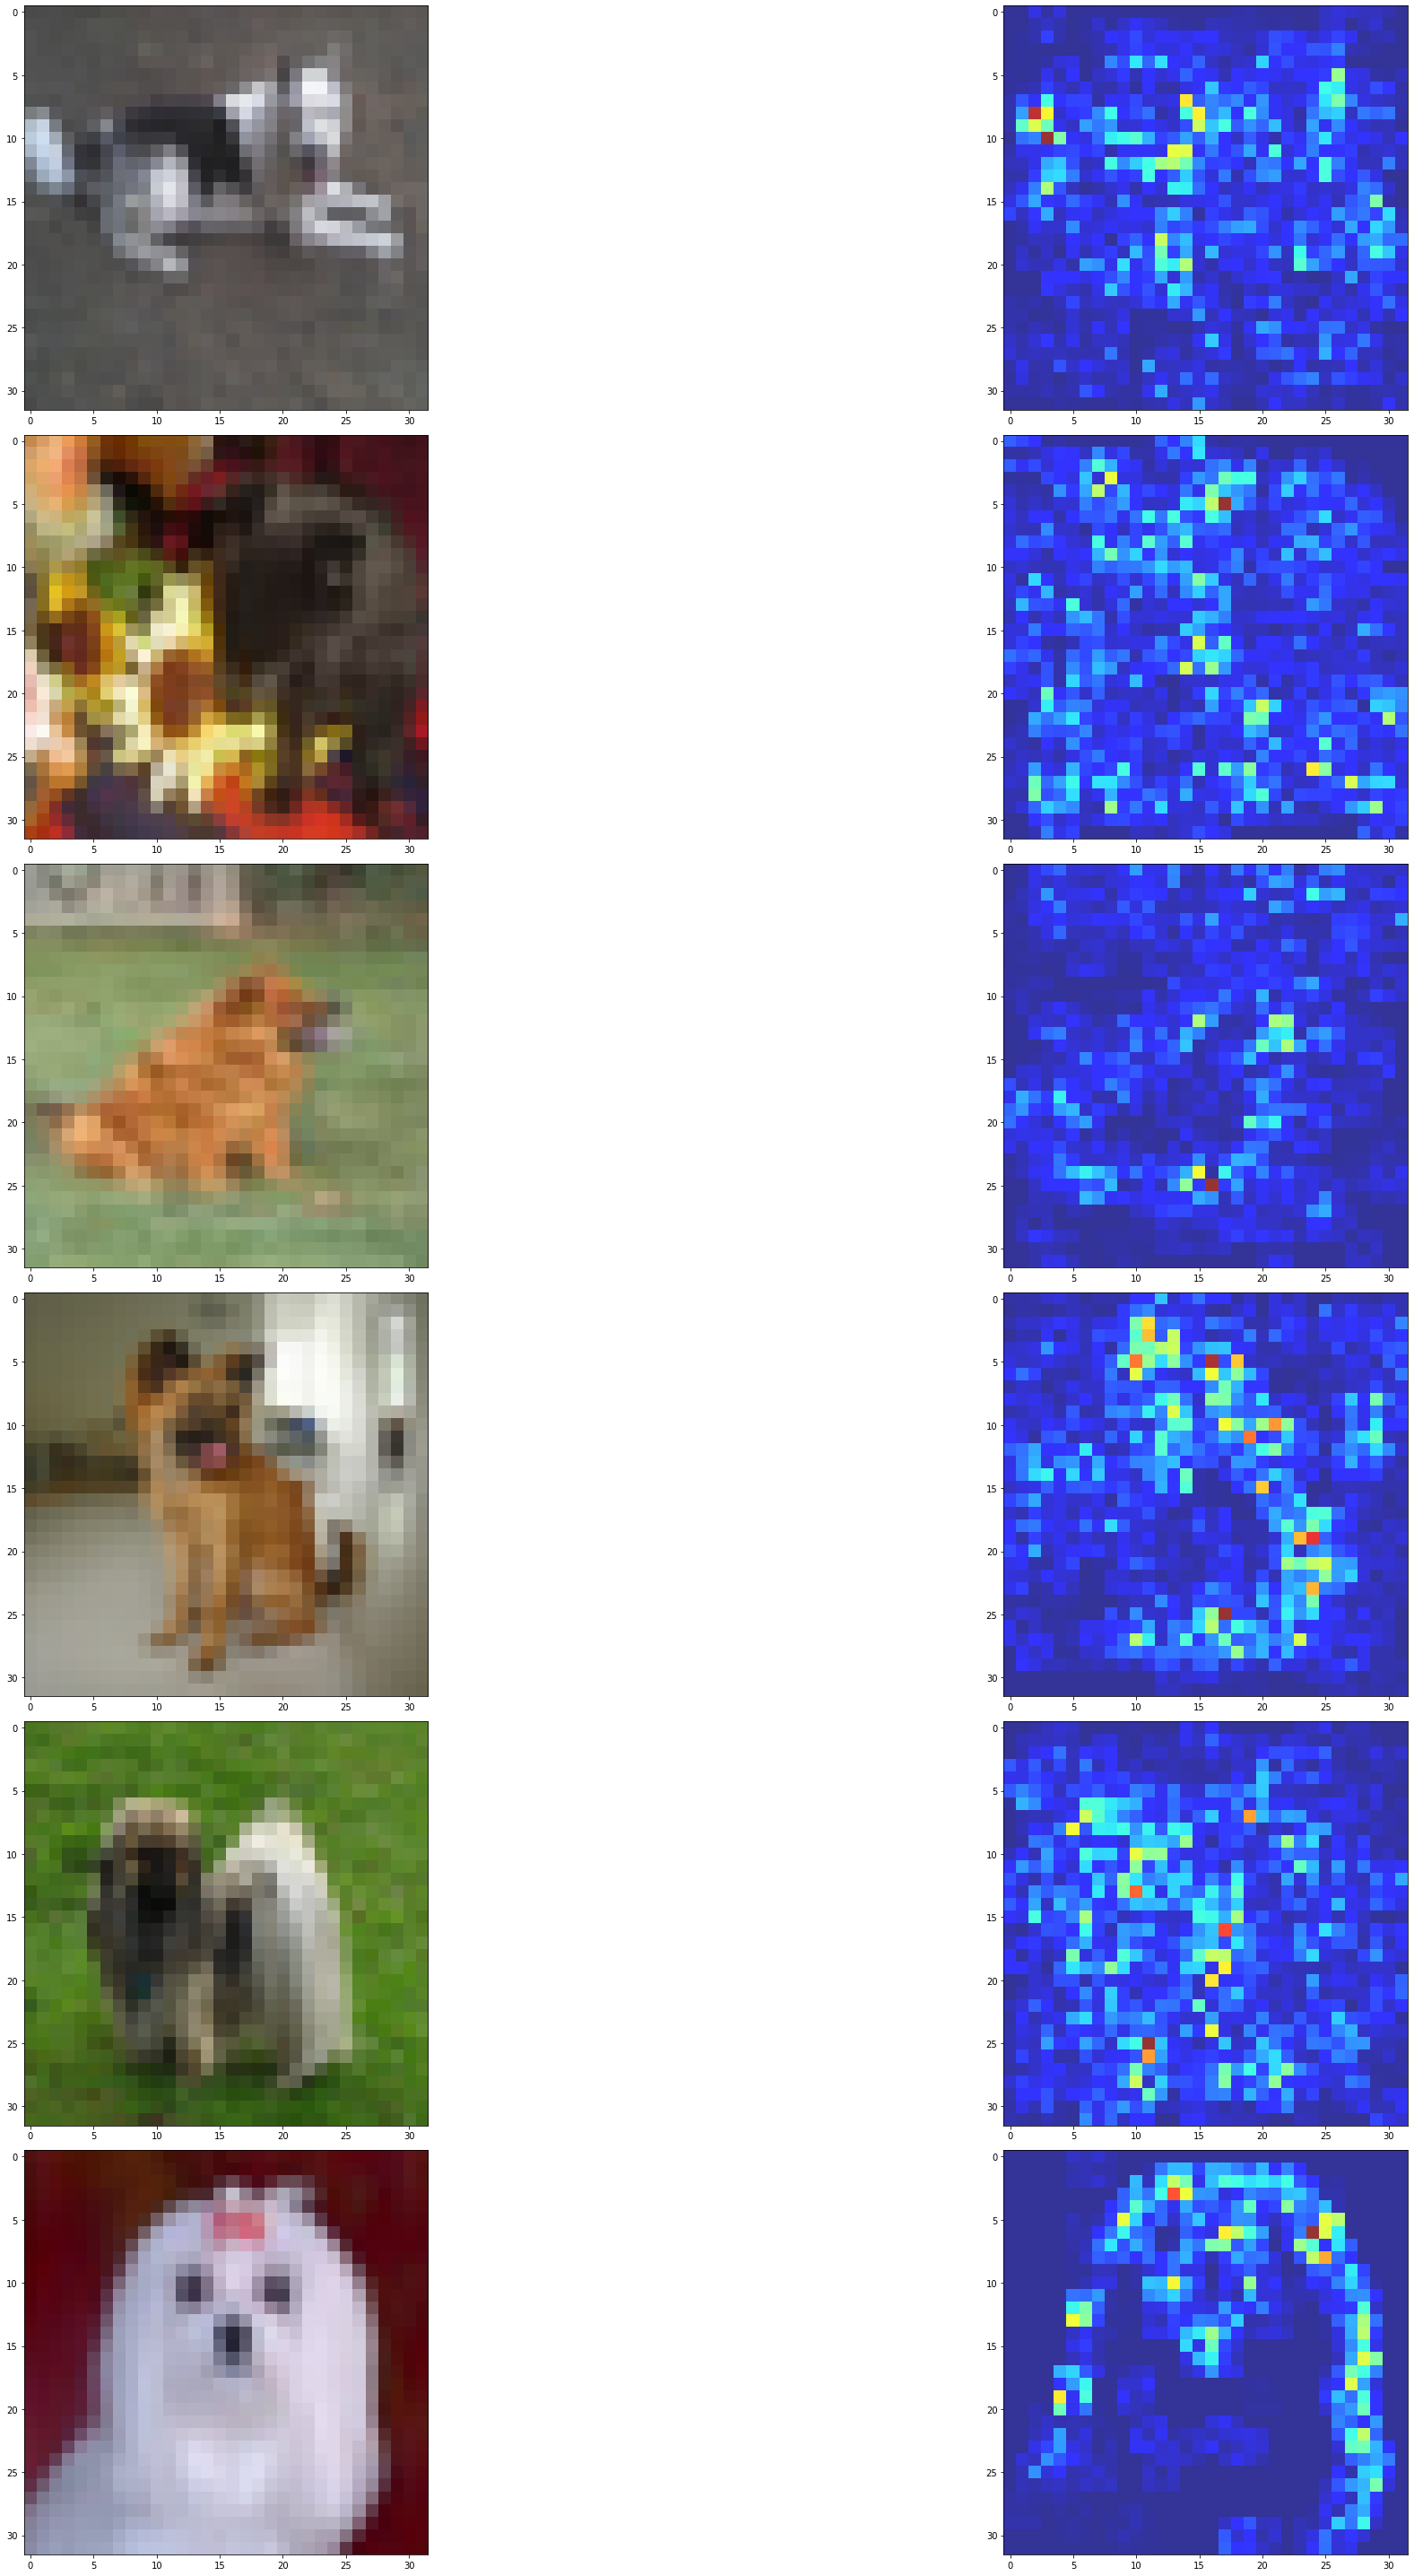

In [ ]:
##Create the subplot object
fig, axes = plt.subplots(6,2,figsize=(40,40))

##Loop through all the random cat images
ct = 0
for i in randDogs:
  map = saliency_map(i,regularModel,x_test)
  axes[ct,0].imshow(np.squeeze(i))
  axes[ct,1].imshow(map,cmap="jet",alpha=0.8)
  ct+=1
fig.tight_layout()

<b>Plot Saliency Maps for Horses:</b>

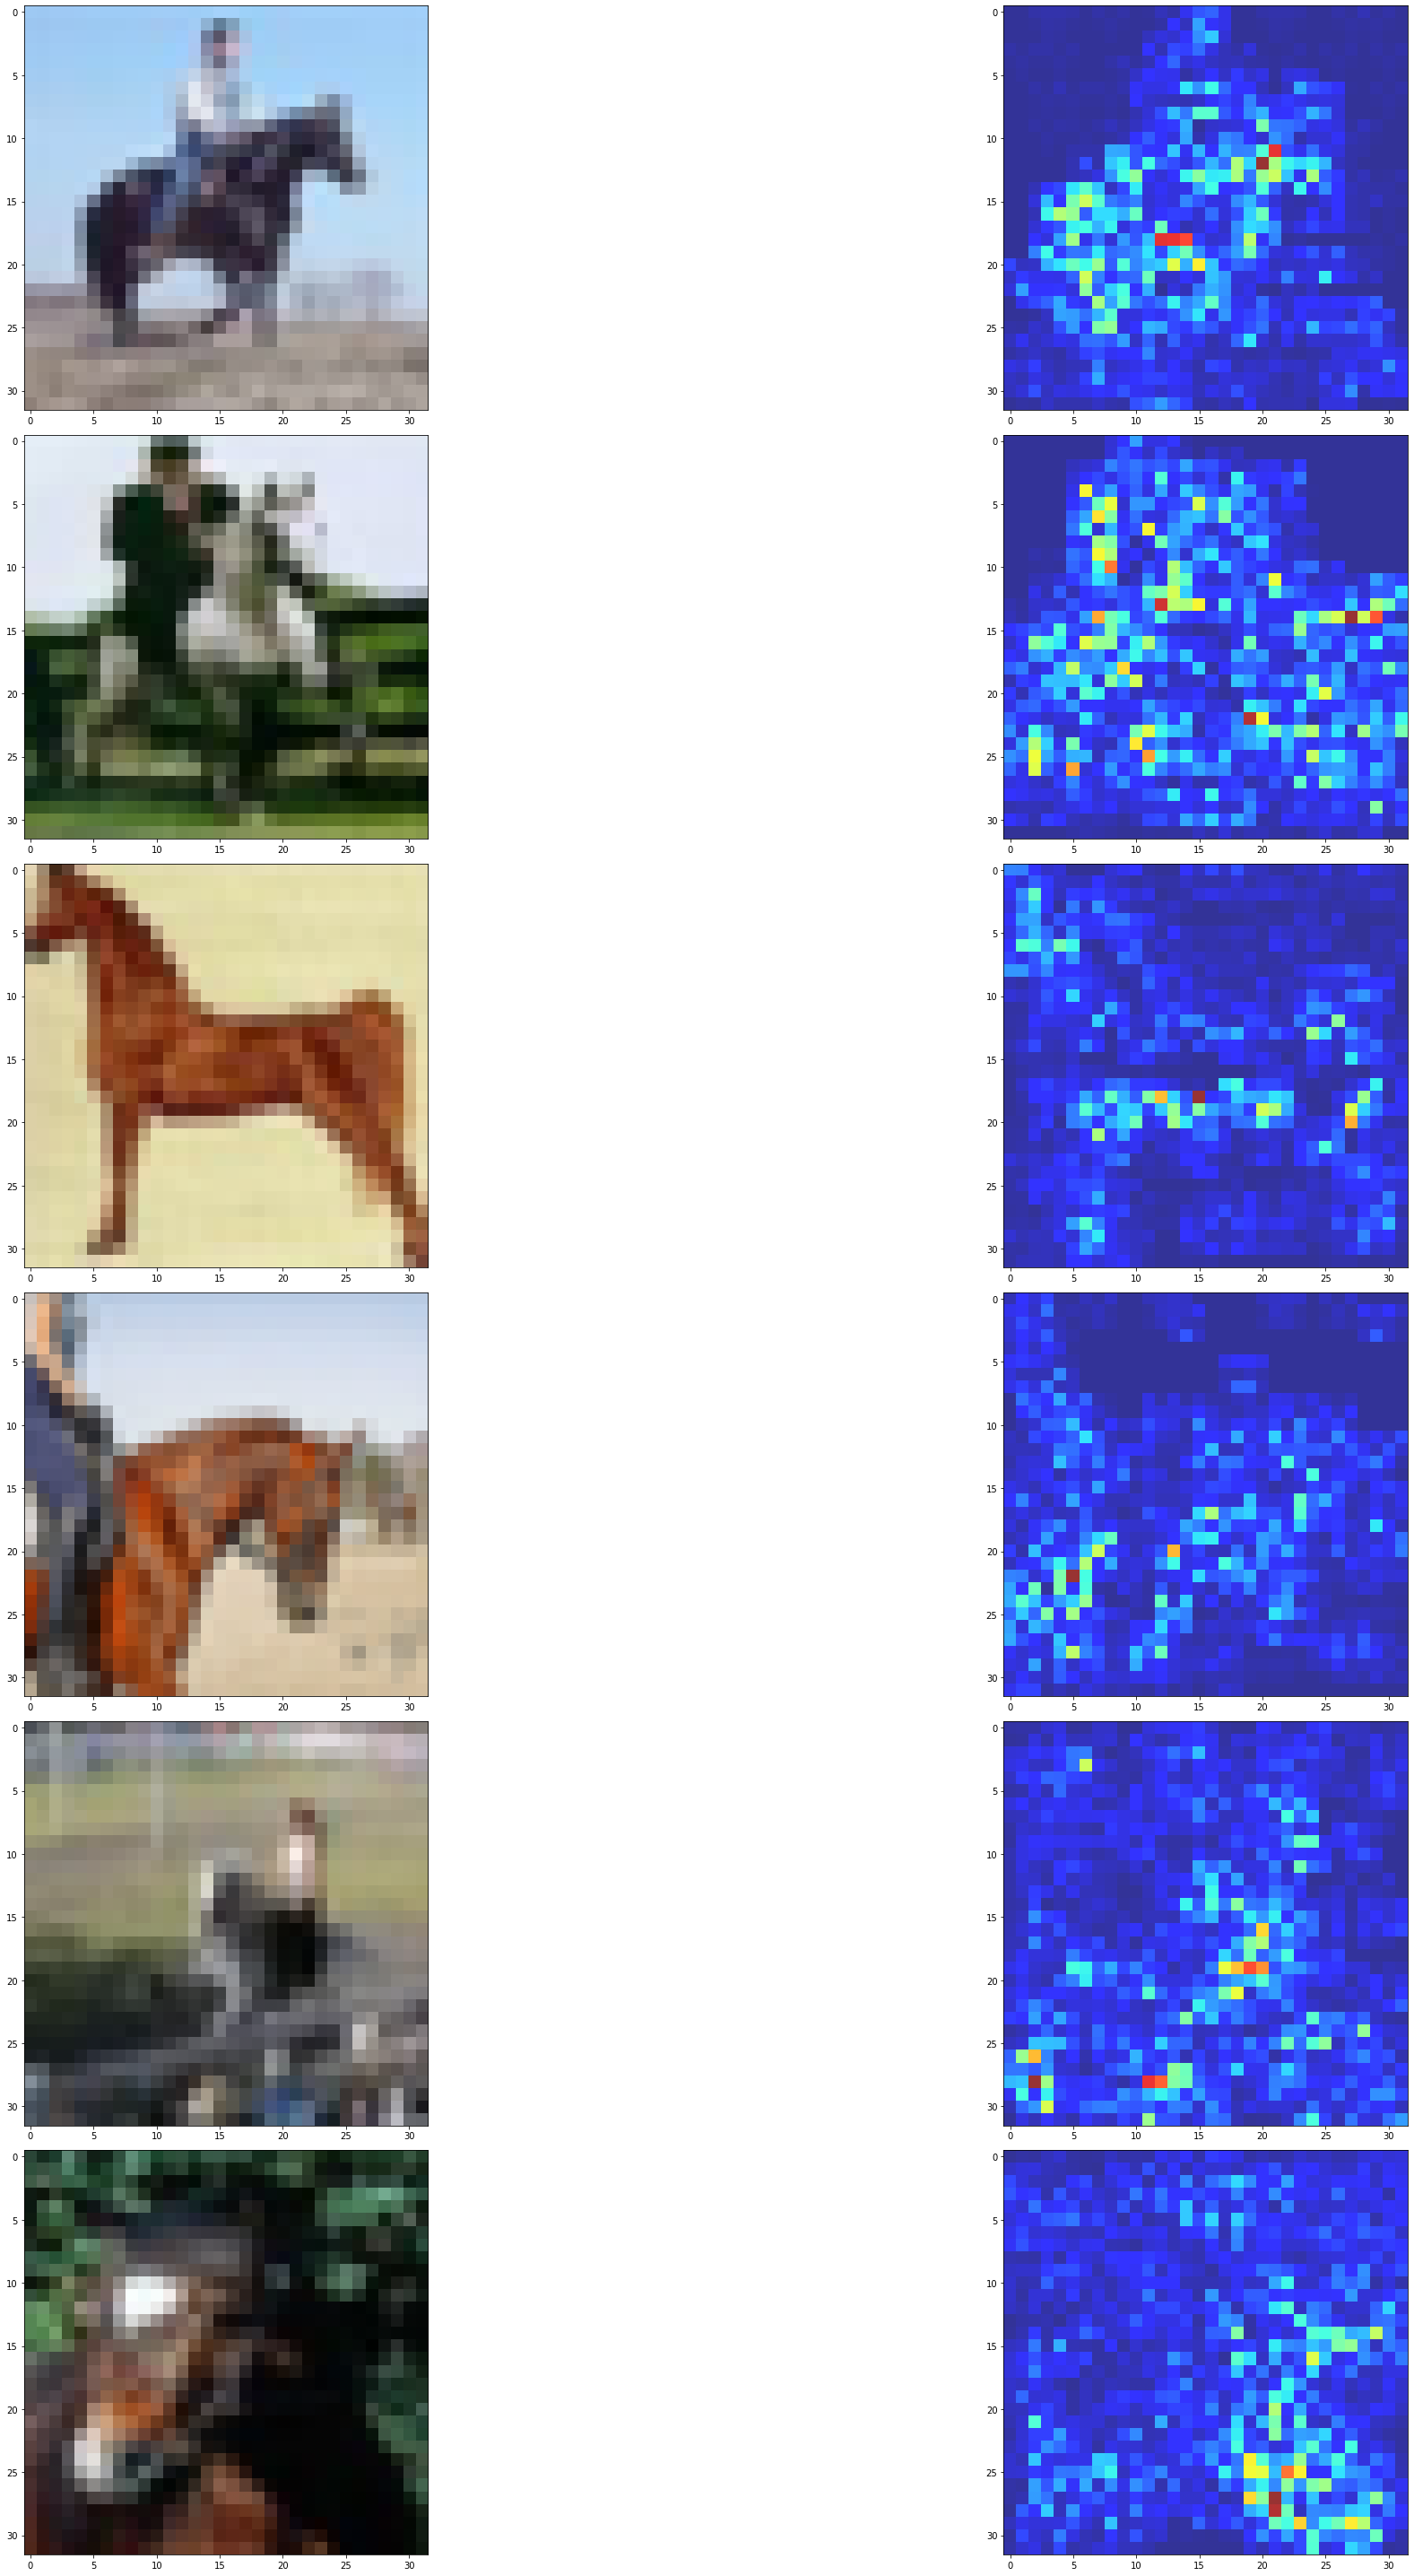

In [ ]:
##Create the subplot object
fig, axes = plt.subplots(6,2,figsize=(40,40))

##Loop through all the random cat images
ct = 0
for i in randHorses:
  map = saliency_map(i,regularModel,x_test)
  axes[ct,0].imshow(np.squeeze(i))
  axes[ct,1].imshow(map,cmap="jet",alpha=0.8)
  ct+=1
fig.tight_layout()

These saliency map results actually turn out to be pretty interesting. It's really cool to see certain examples where the there are higher gradients outlining the shape of the animal. Specifically, in the 2nd row of the horse class saliency maps, the horse's figure is very well defined by the gradients, indicating the algorithm is looking at the correct pixels when making predictions for this image. Here are a few more observations from across all the classes:
* Cat Saliency Maps:
  * Rows 1 and 2 of the Cat saliency maps indicate good importance of pixels as the gradients outline the shapes of the cats as seen in the original image
  * In row 4 of the Cat maps the head and ears of the cat are well outlined by the gradients indicating the shape of a cat's head is important to the algorithm
* Deer Saliency Maps:
  * Row 3 of the Deer maps has a very well-defined deer shape by the gradients and the highest gradients indicated by red and orange pixels reside in the Deer Antler pixels, indicating that the algorithm correctly identifies antlers as a good feature to predict for deer
  * Some other saliency maps for deer are a little more cloudy in terms of their gradient and don't give me great confidence that the algorithm is necessarily looking at the correct pixels to identify the deer
* Dog Saliency Maps:
  * In row 6 of the Dog maps, the dog's head and face is almost perfectly outline telling me the algorithm is looking at the correct pixels of importance
  * Rows 1, 2, 4, and 6 all have high gradients in the pixels where the dogs ears reside, indicating that the algorithm marks dog ears as important pixels, and possibly uses the ears to differenate dogs from cats at times
* Horse Saliency Maps:
  * Row 3 of the horse maps again almost perfectly outlines/fills in the shape of the horse giving me confidence that the algorithm is intelligently predicting this image and not just looking at irrelevant image information
  * Row 6 it seems that the algorithm isn't looking at important pixels as it has very low gradients at the horse's face, which would probably be the most important part of this particular image for predicting it is a horse

### Low Resolution Model

In this next model, I will add a Max-Pooling operation to the first layer of the network to reduce the image resolution right away. Then, I will generate saliency maps for the mammal classes again to assess if the pixels with the highest gradients have changed drastically or not. 

In [6]:
##Create model
lowModel = tf.keras.models.Sequential()

##Add a layer with 32 filters for a 1x1 convolution
lowModel.add(tf.keras.layers.Conv2D(32, (1, 1), activation='relu', input_shape=(32,32,3))) ##Grayscale input shape
lowModel.add(tf.keras.layers.MaxPooling2D((3, 3),padding='valid')) ##Perform a 3x3 max-pooling

##Add a layer that generates 64 feature maps and max pools again with 3x3 
lowModel.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
lowModel.add(tf.keras.layers.MaxPooling2D((3, 3)))

##Perform final convolution operations and conduct global average pooling
lowModel.add(tf.keras.layers.Conv2D(64, (1, 1), activation='relu'))
lowModel.add(tf.keras.layers.GlobalAveragePooling2D())

##Add a single dense layer after global average pooling
lowModel.add(tf.keras.layers.Dense(4, activation='softmax')) ##Must have 9 neurons

In [7]:
##Compile the model
lowModel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

##Split training data so we have a validation set
from sklearn.model_selection import train_test_split
x_train_low, x_val, y_train_low, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [8]:
##Fit our created model over 50 epochs
lowModel_fit = lowModel.fit(x_train_low, y_train_low, batch_size=32, epochs=50, validation_data=(x_val, y_val),verbose=2)

Epoch 1/50
469/469 - 33s - loss: 1.8107 - accuracy: 0.3814 - val_loss: 1.2848 - val_accuracy: 0.4178
Epoch 2/50
469/469 - 2s - loss: 1.2426 - accuracy: 0.4495 - val_loss: 1.2522 - val_accuracy: 0.4256
Epoch 3/50
469/469 - 2s - loss: 1.1882 - accuracy: 0.4696 - val_loss: 1.3124 - val_accuracy: 0.4284
Epoch 4/50
469/469 - 2s - loss: 1.1567 - accuracy: 0.4801 - val_loss: 1.1061 - val_accuracy: 0.5174
Epoch 5/50
469/469 - 2s - loss: 1.1272 - accuracy: 0.4970 - val_loss: 1.1117 - val_accuracy: 0.5148
Epoch 6/50
469/469 - 2s - loss: 1.1140 - accuracy: 0.5082 - val_loss: 1.1535 - val_accuracy: 0.4882
Epoch 7/50
469/469 - 2s - loss: 1.0873 - accuracy: 0.5198 - val_loss: 1.0733 - val_accuracy: 0.5384
Epoch 8/50
469/469 - 2s - loss: 1.0719 - accuracy: 0.5261 - val_loss: 1.0540 - val_accuracy: 0.5536
Epoch 9/50
469/469 - 2s - loss: 1.0523 - accuracy: 0.5404 - val_loss: 1.0698 - val_accuracy: 0.5484
Epoch 10/50
469/469 - 2s - loss: 1.0351 - accuracy: 0.5483 - val_loss: 1.0473 - val_accuracy: 0.559

In [10]:
##Evaluate the models accuracy on the MNIST dataset
print('Test Accuracy of Low Resolution Model:')
lowModel.evaluate(x_test,  y_test, verbose=0)[1]

Test Accuracy of Low Resolution Model:


0.5755000114440918

This is similar accuracy to the first higher resolution model, coming in at 57.55%. It is slightly lower accuracy on the test data but the difference isn't great enough to raise any red flags about how the model is making its decisions. 

Again I will plot the saliency maps and then perform an analysis on them at the end. 

<b>Plot Saliency Maps for Cats:</b>

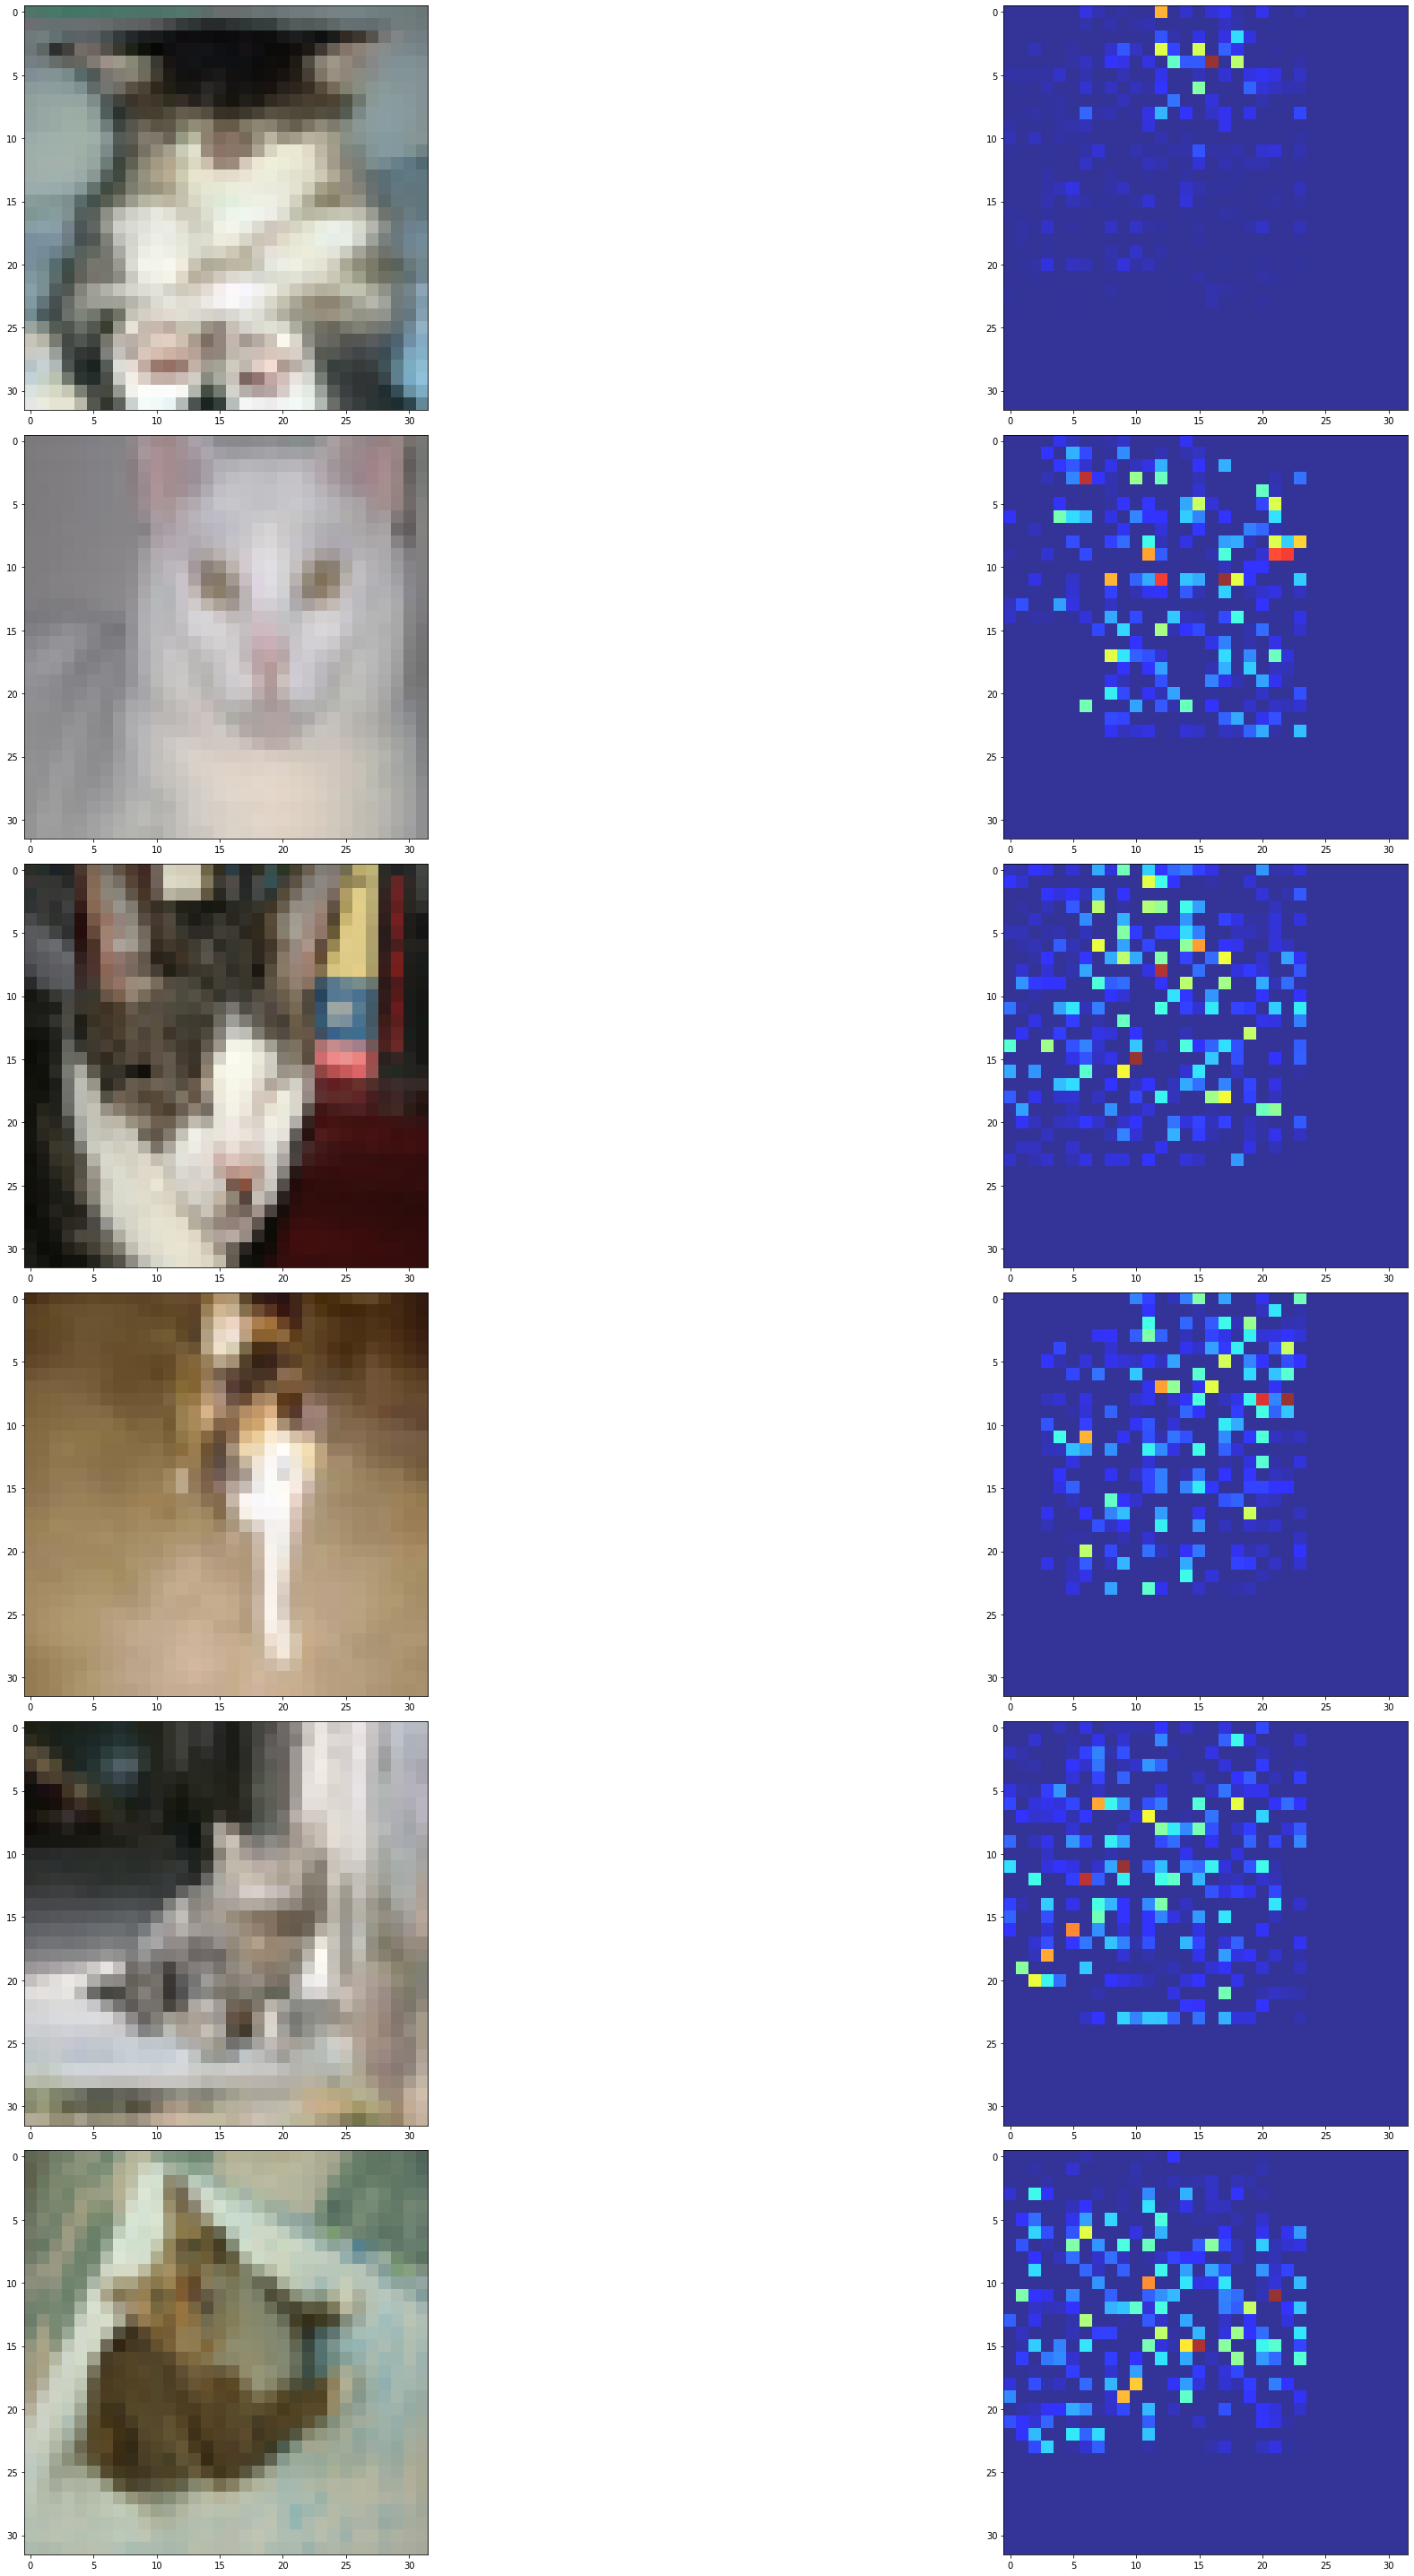

In [17]:
##Create the subplot object
fig, axes = plt.subplots(6,2,figsize=(40,40))

##Loop through all the random cat images
ct = 0
for i in randCats:
  map = saliency_map(i,lowModel,x_test)
  axes[ct,0].imshow(np.squeeze(i))
  axes[ct,1].imshow(map,cmap="jet",alpha=0.8)
  ct+=1
fig.tight_layout()

<b>Plot Saliency Maps for Deer:</b>

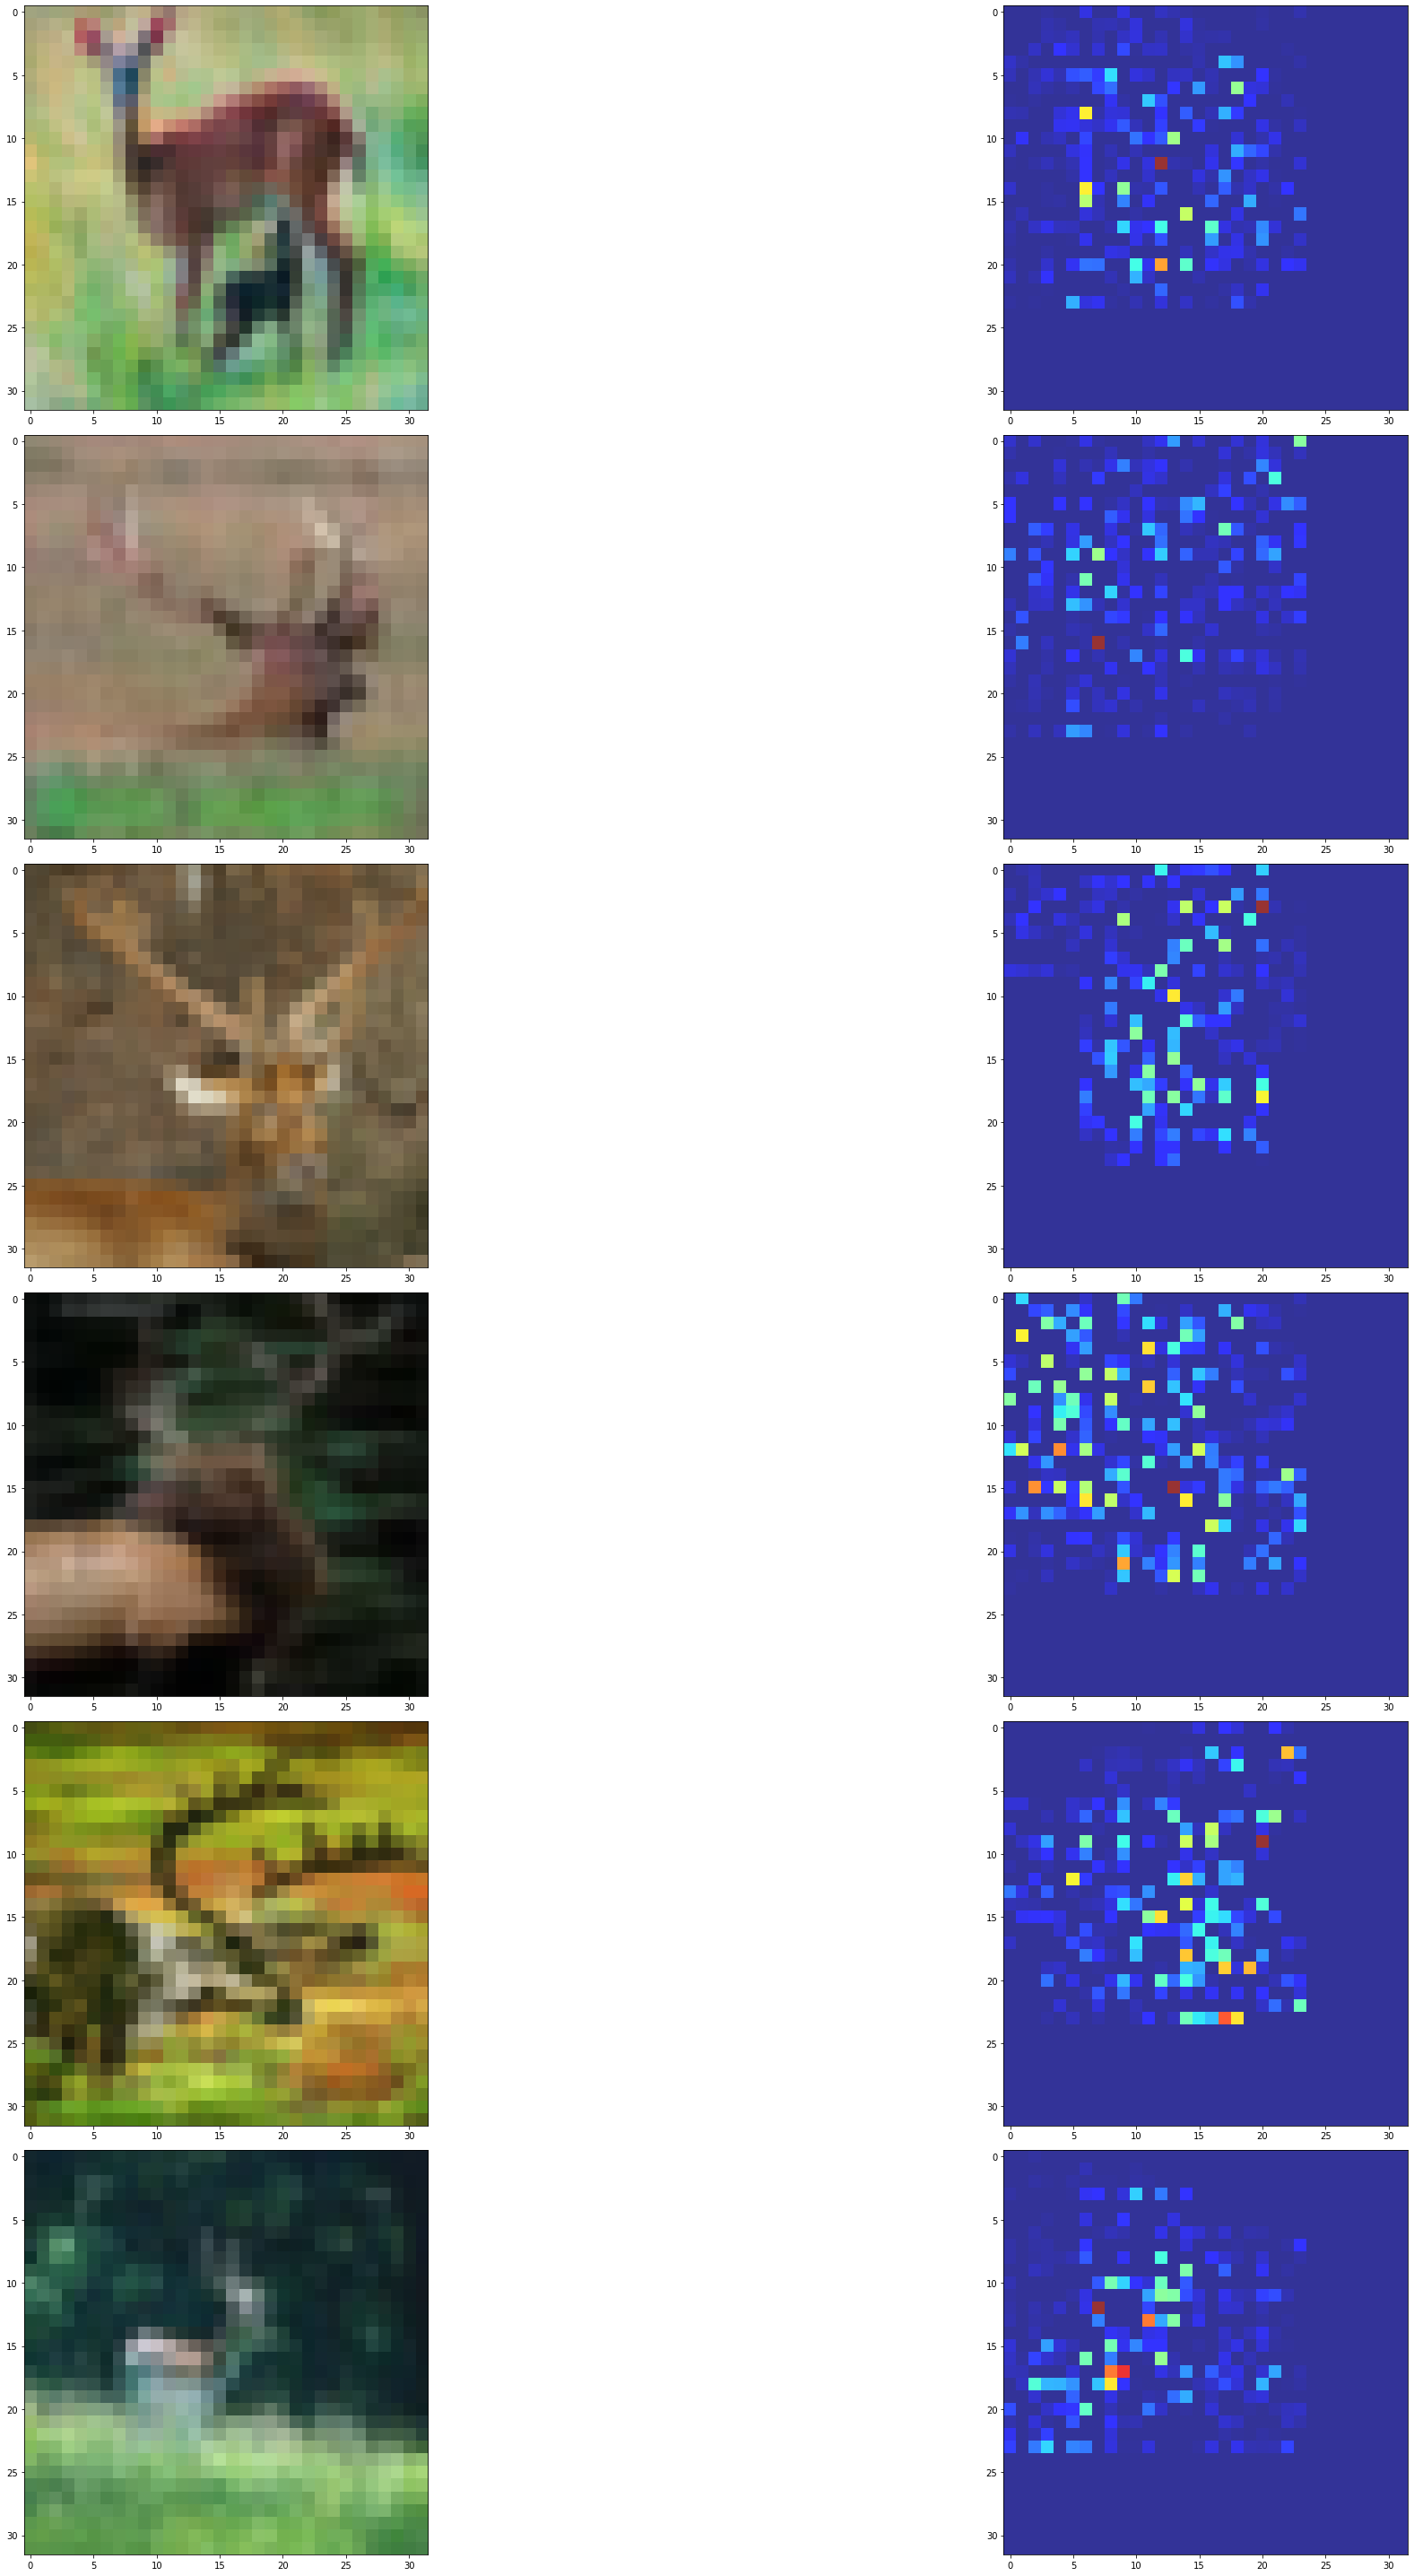

In [18]:
##Create the subplot object
fig, axes = plt.subplots(6,2,figsize=(40,40))

##Loop through all the random cat images
ct = 0
for i in randDeer:
  map = saliency_map(i,lowModel,x_test)
  axes[ct,0].imshow(np.squeeze(i))
  axes[ct,1].imshow(map,cmap="jet",alpha=0.8)
  ct+=1
fig.tight_layout()

<b>Plot Saliency Maps for Dogs:</b>

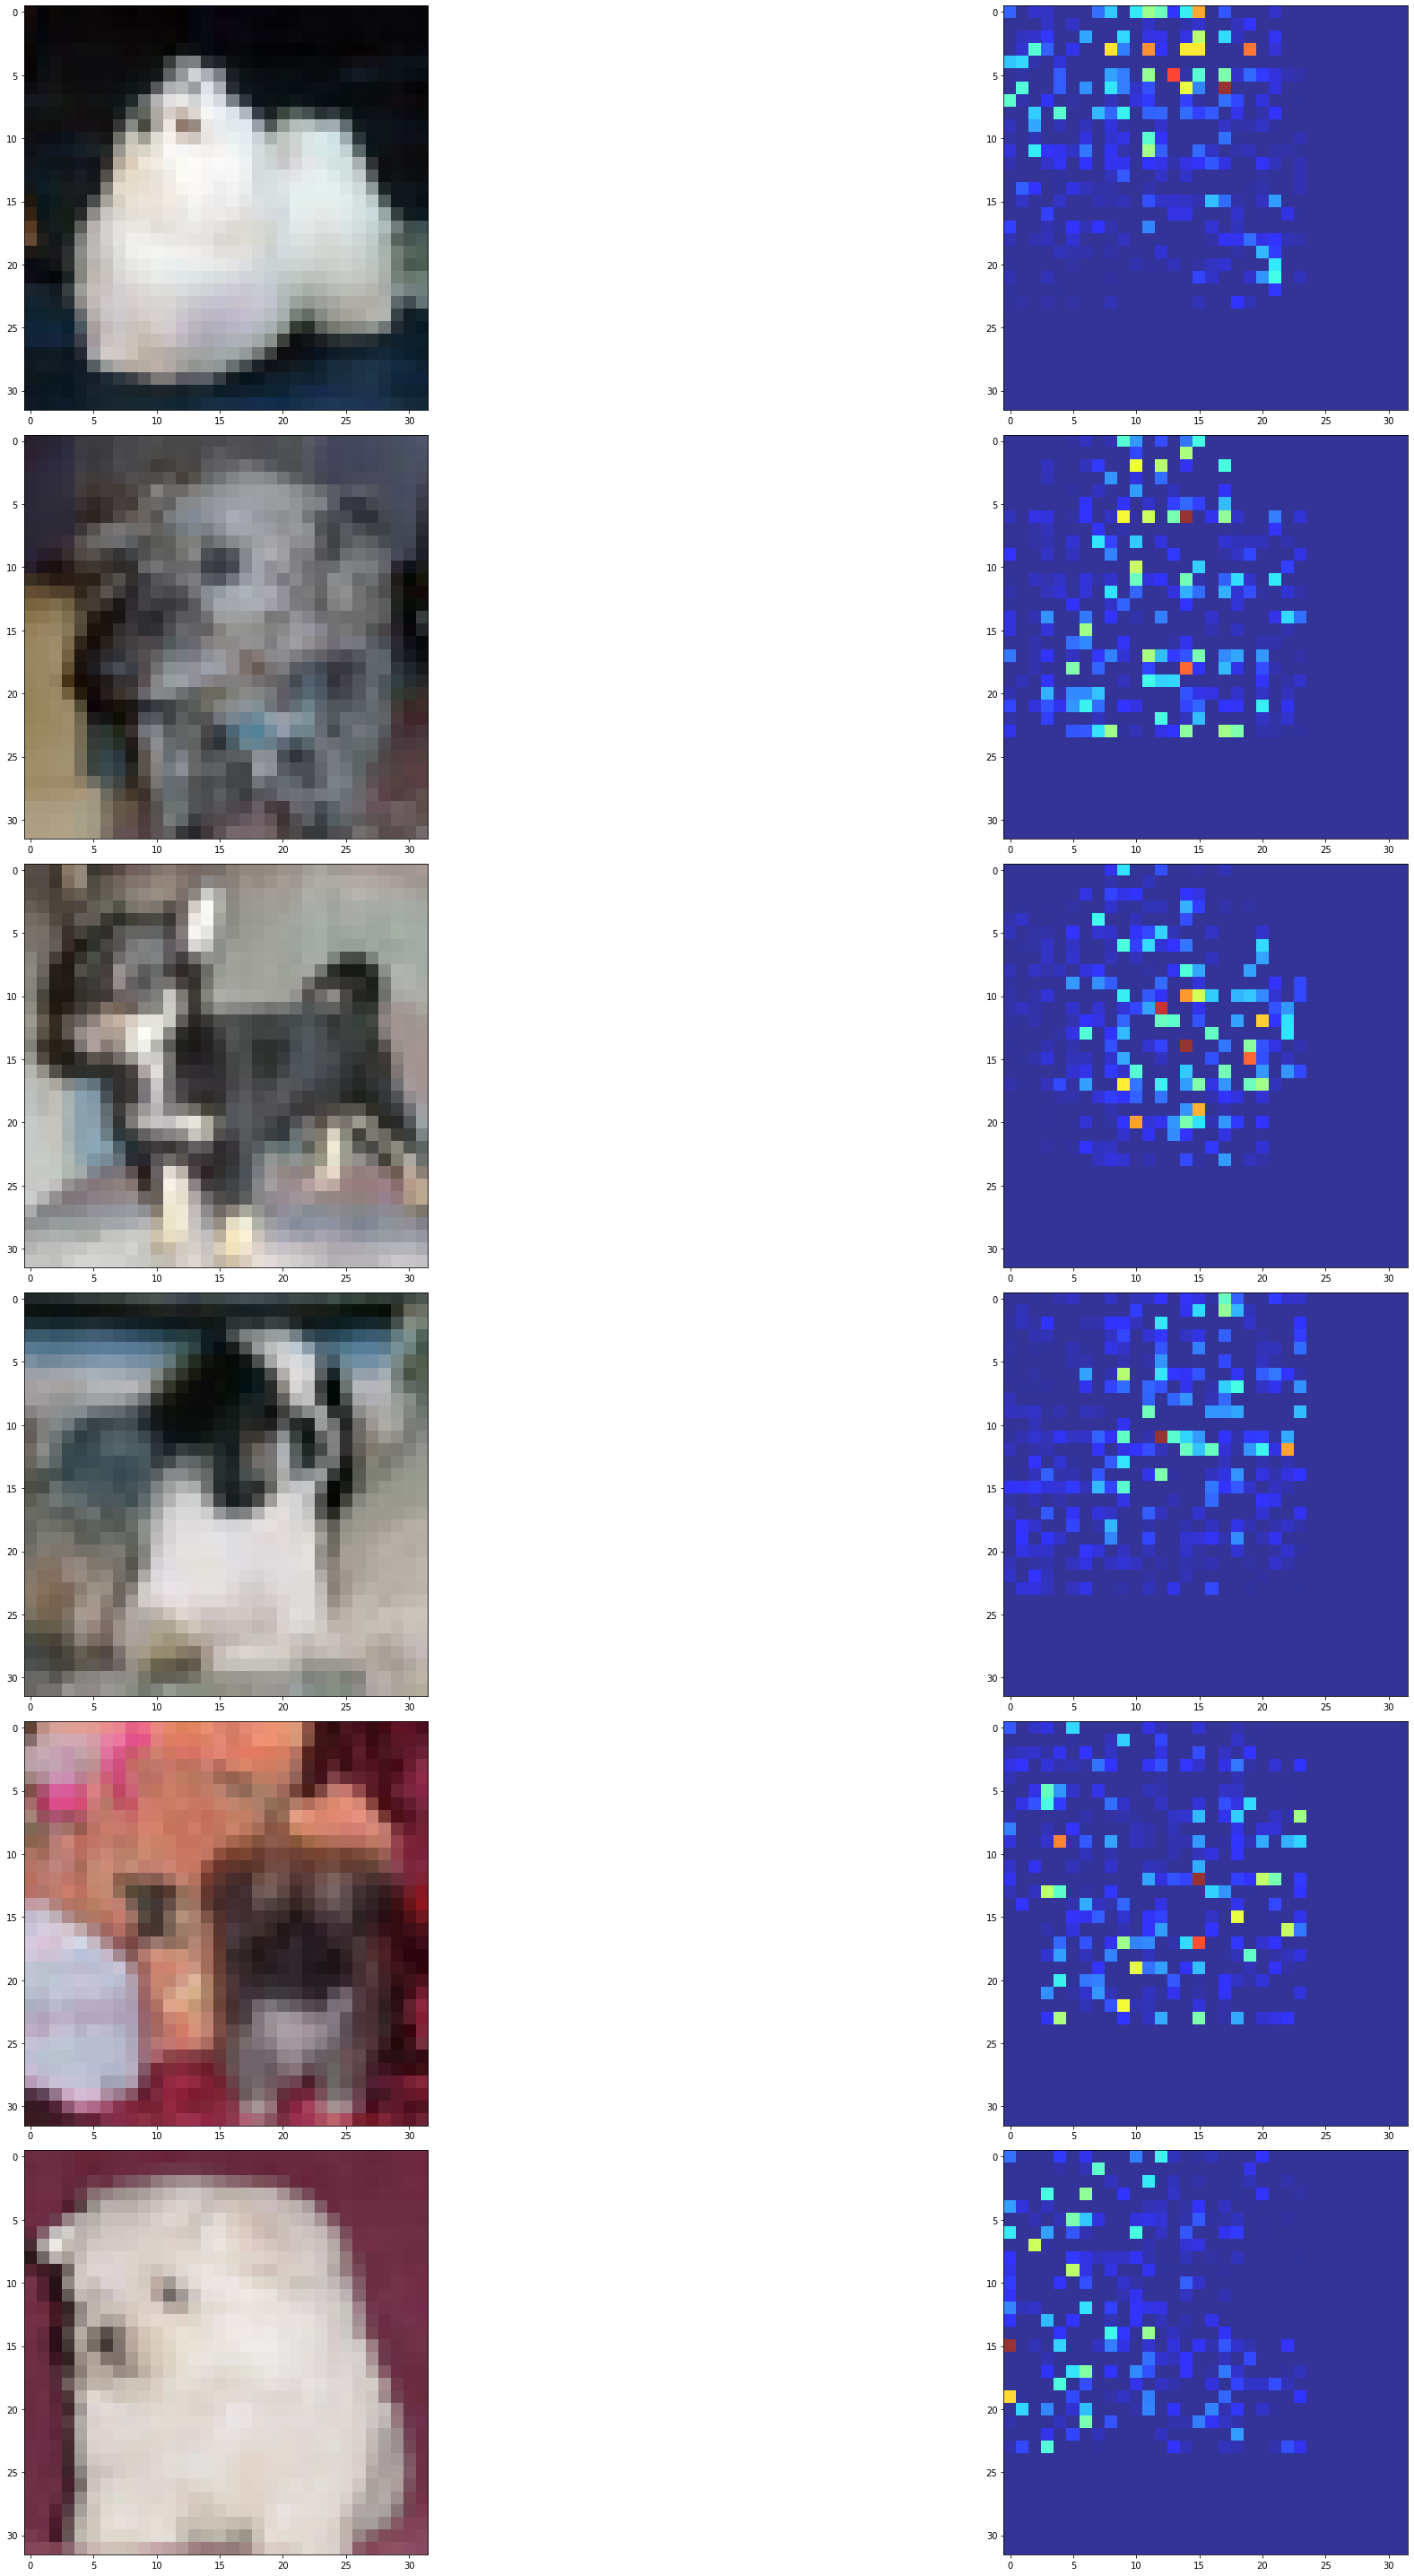

In [19]:
##Create the subplot object
fig, axes = plt.subplots(6,2,figsize=(40,40))

##Loop through all the random cat images
ct = 0
for i in randDogs:
  map = saliency_map(i,lowModel,x_test)
  axes[ct,0].imshow(np.squeeze(i))
  axes[ct,1].imshow(map,cmap="jet",alpha=0.8)
  ct+=1
fig.tight_layout()

<b>Plot Saliency Maps for Horses:</b>

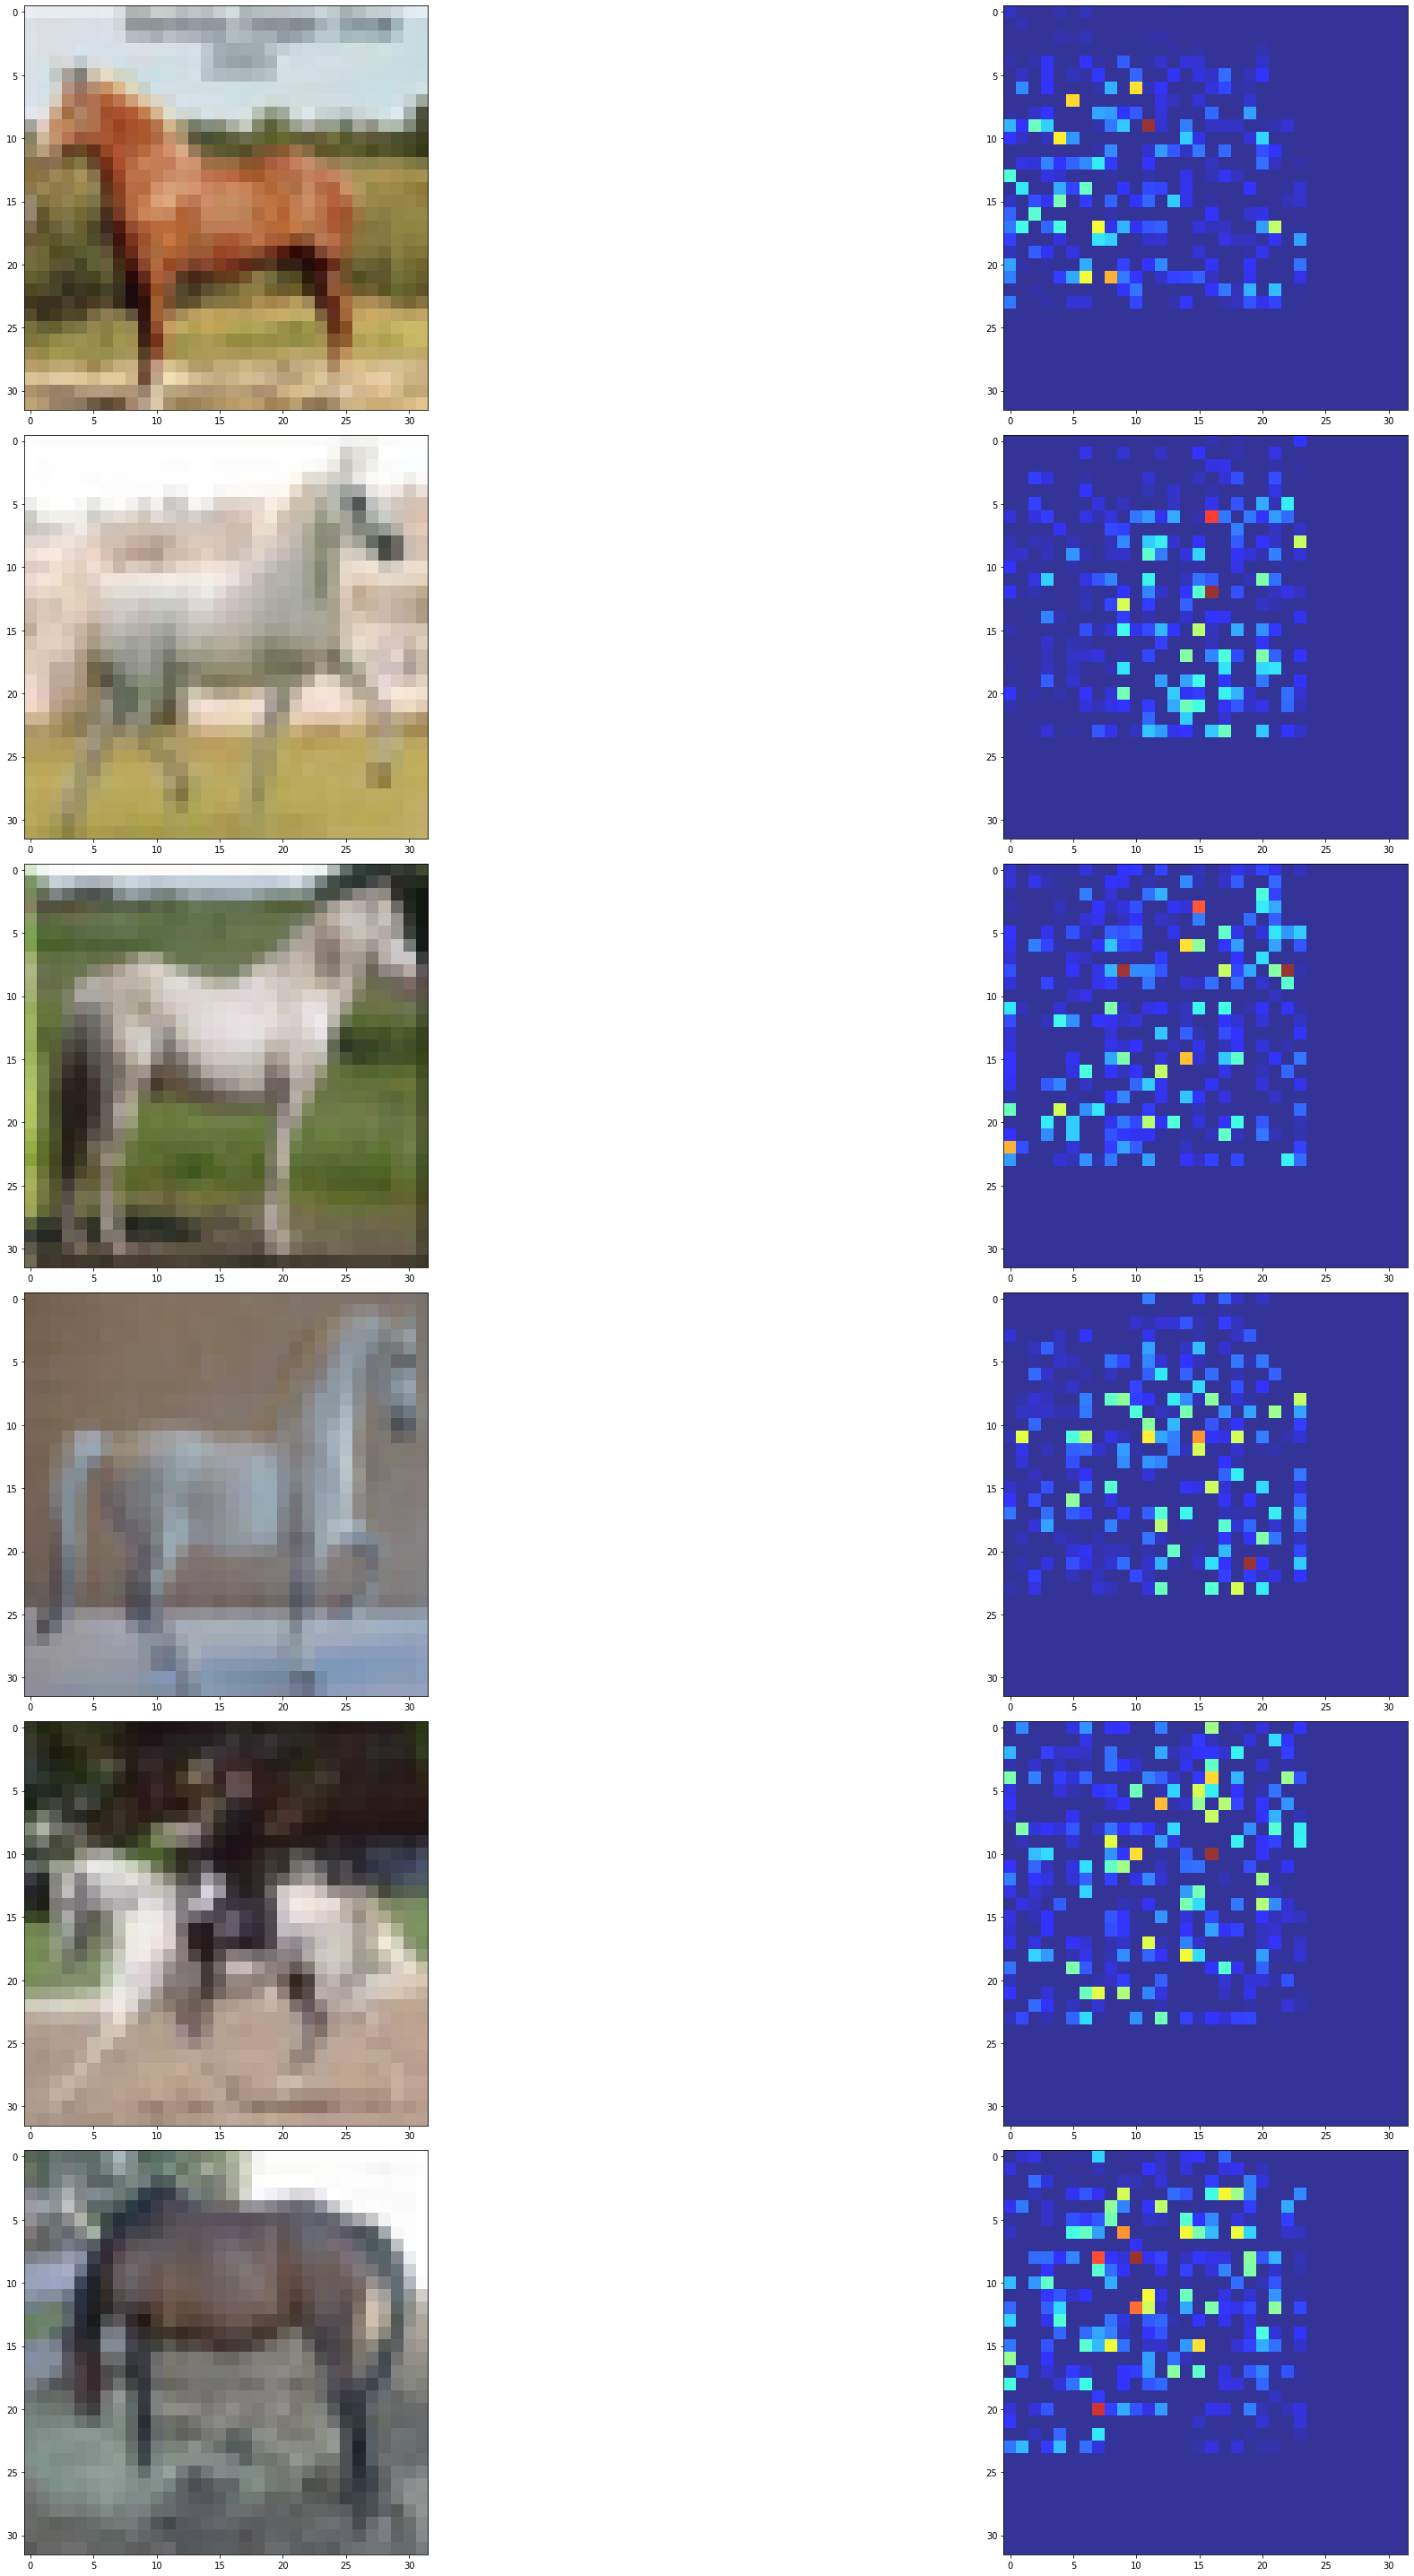

In [20]:
##Create the subplot object
fig, axes = plt.subplots(6,2,figsize=(40,40))

##Loop through all the random cat images
ct = 0
for i in randHorses:
  map = saliency_map(i,lowModel,x_test)
  axes[ct,0].imshow(np.squeeze(i))
  axes[ct,1].imshow(map,cmap="jet",alpha=0.8)
  ct+=1
fig.tight_layout()

So the immediate observations about these new saliency maps has to do with the padding resolution reduction introduced by the max-pooling operation in the first layer. I chose to do "valid" padding with this max-pooling operation which essentially drops pixels that don't fit into the padding window. We can see this effect on our saliency maps as there are no gradients above 0 on the whole bottom side and right side of our images, which makes sense because these pixels were dropped as a result of valid padding. It is actually pretty obvious looking through these images that the model loses quite a bit of important pixels by doing this. Here are some more specific examples:
* Cat Saliency Maps:
  * There is not a cat example where we can see that gradients outlining the shape of the cat, it is typically just a cloud of gradients in the upper-left hand corner region of the images
  * This makes me less confident that the network is making educated decisions when predicting cats
* Deer Saliency Maps:
  * In rows 4 and 5 the gradients seem to be higher where the deer's antlers are in the images, this is a good sign indicating the network is still attributing importance to the presence of antlers
* Dog Saliency Maps:
  * In Row 1 the high gradients appear to be above the body of the dog concentrated on the background hinting that the network is not looking at relevant pixels for this image
  * In Row 4 some higher pixel gradients are concentrated on the dogs face but they don't explicitly outline details of the face like they did when we used the higher resolution model
* Horse Saliency Maps:
  * Rows 1, 2, 3, and 4 appear to have higher gradients mostly focused on the horses body but it is obvious that the introduced padding is blocking a lot of information from the network
  * Rows 5 and 6 are more concerning in that it seems several higher gradient pixels are for the background of the image, which the model shouldn't be making decisions based off of. 

## Final Thoughts

I enjoyed performing the Saliency Map analysis from the <b>Visualizing and Understanding</b> module as it was my first time really seeing how the models I'm making are actually making decisions. Based off my observations, I would say that I have a much greater confidence in the high resolution model than the low resolution model even though the accuracies were almost identical. This is because it is much more obvious that the high resolution network is making decisions based off the actual mammal featured in the image whereas the low resolution model focused more on background information and at times it was hard to tell what the model was actually looking at. 

As the class moves forward to <b>Transfer Learning</b> in a couple weeks, it might also be interesting to see what effects transfer learning has on a models saliency maps. 